** *
# Microsoft Malware Classification Challenge (BIG 2015)

---


https://www.kaggle.com/c/malware-classification/


>[Microsoft Malware Classification Challenge (BIG 2015)](#scrollTo=zMYQUkNl3e3I)

>[Initial Setup](#scrollTo=U0PO6PE-0JFr)

>>[Download Dataset](#scrollTo=afqc3ABYzOTC)

>[Extract Features](#scrollTo=ms9rLqS_pgRl)

>>[Dataset Analysis](#scrollTo=ZHQsbeIybpeq)

>>[Split train and valid set](#scrollTo=xBoVaLxnqveu)

>>[Saving processed data](#scrollTo=_7pE87gkp-yb)

>>[N-grams](#scrollTo=qYMaw8Q0kFjx)

>[Train classification model](#scrollTo=Dc4gptW2kWbl)

>>[Tree Ensemble](#scrollTo=w2LFKtSuwir-)

>>[Boosting trees](#scrollTo=L9I6g8_tzStG)

>[Performance evaluation](#scrollTo=6vpKGzmtlIji)



# Initial Setup

## Download Dataset

In [18]:
!pip install kaggle

In [19]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

if not os.path.exists('data/'):

    auth.authenticate_user()

    drive_service = build('drive', 'v3')
    results = drive_service.files().list(
            q="name = 'kaggle.json'", fields="files(id)").execute()
    kaggle_api_key = results.get('files', [])

    filename = "/content/.kaggle/kaggle.json"
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
    fh = io.FileIO(filename, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print("Download %d%%." % int(status.progress() * 100))
    os.chmod(filename, 600)

    !kaggle competitions download -c malware-classification -p data/
    
else:
    print('Dataset already downloaded!')

Dataset already downloaded!


In [20]:
import re
import glob
from tqdm import tqdm
#from tqdm import tqdm_notebook


import numpy as np
import pandas as pd

import multiprocessing
from multiprocessing.dummy import Pool

In [21]:
seed=42
np.random.seed(seed)

In [22]:
cpu_count  = 2*multiprocessing.cpu_count()-1
print('Number of CPUs: {}'.format(cpu_count))

Number of CPUs: 3


In [23]:
!cd data && p7zip -d train.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 18810691091 bytes (18 GiB)

Extracting archive: train.7z
--
Path = train.7z
Type = 7z
Physical Size = 18810691091
Headers Size = 339764
Method = LZMA:24
Solid = +
Blocks = 94

  0%      0% - train/01azqd4InC7m9JpocGv5.asm                                       0% 1 - train/01IsoiSMh5gxyDYTl4CB.asm                                         0% 2 - train/01jsnpXSAlgw6aPeDxrU.asm                                         0% 6 - train/02JqQ7H3yEoD8viYWlmS.asm

                                          0% 58 - train/0BKcmNv4iGY2hsVSaXJ6.asm                                          0% 59 - train/0BLbmzJRkjNynCgQIdtV.asm                                          0% 60 - train/0bN6ODYWw2xeCQBn3tEg.asm                                          0% 64 - train/0cdnSIvN489sFUwYlrMQ.asm                                          0% 67 - train/0cGWK6VvCkm7O2AxDjtw.asm                                          0% 68 - train/0cH8YeO15ZywEhPrJvmj.asm

                                           1% 121 - train/0GUIi7xAlODwZ4YBenNM.asm                                           1% 122 - train/0gUpzkLVT73PCXx5WFRI.asm                                           1% 123          1% 123 - train/0GuYe4J7oLwQ82xr3pWS.asm                                           1% 124 - train/0GVcTdBQXWUJ2t7vjphN.asm                                           1% 127 - train/0gxJ1YmwFUvnOzoM8N53.asm                                           1% 128 - train/0H5OFklQ

                                           1% 189 - train/0m94tRnhgpsAUuY1L8KC.asm                                           1% 190 - train/0mcWyK6unLRGV8Hfr97Y.asm                                           1% 192 - train/0mfwTlekXE1poYAnqMRO.asm                                           1% 194 - train/0mlhuKGpCc6OB4zwrbLy.asm                                           1% 195 - train/0MmZ8j5pn2R3VG9wlxYi.asm                                           1% 197 - train/0MpJYhdbf8T7InoqcXr1.asm

                                           2% 271 - train/0sYDNzwVMaWE2TIZeA81.asm                                           2% 275 - train/0TqZzRJOeno9NKpHIba5.asm                                           2% 277 - train/0tZy7jgOKCIJslPRvrop.asm                                           2% 281 - train/0UcDbq2yojiThfdLRNS4.asm                                           2% 285 - train/0uNkt6sirCnUWw175pjl.asm                                           2% 286 - train/0URC4HAzJrjWnDVMXF1x.asm

                                           2% 366 - train/175ZU8ClOsnifz03ybcX.asm                                           2% 368 - train/17jNaPkYIgvUyw9HxC5D.asm                                           2% 372 - train/18A9fzqbeyripCSuLKo4.asm                                           2% 373 - train/18AD5lV4StiZfN0pmdGj.asm                                           2% 374 - train/18eZt9qWksQhoY3K60aE.asm                                           2% 376 - train/18SQsaz6lMJIZCknYpgL.asm

                                           3% 439 - train/1eAC0zqkIGHRBvm97P6i.asm                                           3% 440 - train/1eCQkhvgDSFNXYLJbAdj.asm                                           3% 441 - train/1EDNRfXhHWl7txAOdycU.asm                                           3% 444 - train/1el4qZPVwIXavrChcyGp.asm                                           3% 448 - train/1EWLhwV47I6HYktzXsmS.asm                                           3% 451 - train/1F7jeznmCoiBxNdIKsWT.asm

                                           3% 527 - train/1LSYgNjTd3GmlvRMP5Do.asm                                           3% 530 - train/1LZcKGIkna9HU7vXl3YN.asm                                           3% 531 - train/1M9k5toHiWfZcLzrdFlw.asm                                           3% 533 - train/1MjkqlJ7L6EoAPXb2fKV.asm                                           3% 536 - train/1MQI2rYz86Sbxa5WhCFG.asm                                           3% 537 - train/1MsThSACGflQ7u8cp40o.asm

                                           4% 603 - train/1T0BWPoJVtNFzsycKhlr.asm                                           4% 604 - train/1T3m7BMCLXpu9JjyKH8R.asm                                           4% 609 - train/1TLN456WuaqCsDr9pv0z.asm                                           4% 612 - train/1txR5rhb4MwNvXuPAFpz.asm                                           4% 615 - train/1u3PmQiD0bX6RcgoCNKe.asm                                           4% 616 - train/1u3qTGiRvckQZW7dBY58.asm

                                           4% 675 - train/20oPR6DZCFTuXi3tqhev.asm                                           4% 678 - train/21l6VM9tKEuCUhL7DjeY.asm                                           4% 679 - train/21OaoipR7tqxzF4HQ9f0.asm                                           4% 681 - train/21S5IzZvPWd0MQr9yoq4.asm                                           4% 682 - train/21XVtgk6bMRdLWP4xoKs.asm                                           4% 685 - train/23iLdjsJ6c01QNkrIRXD.asm

                                           4% 765 - train/2ec5nrOmxDFqKTf3pYGA.asm                                           5% 765 - train/2ec5nrOmxDFqKTf3pYGA.asm                                           5% 766 - train/2ECqL8au6iS3jNJDoOdn.asm                                           5% 769 - train/2edniWaG7lVIHuAsN1MQ.asm                                           5% 774 - train/2ENGLoTqp5wy8YQcSUxK.asm                                           5% 775 - train/2Ep7f84CvJDn9NwMHBPK.asm

                                           5% 846 - train/2L8o4lH63UGR1hPEnztQ.asm                                           5% 852 - train/2lUahz5WrDpB6ejTcYtL.asm                                           5% 853 - train/2lv0CPzQVLwtcAKZT1FB.asm                                           5% 854 - train/2M4c9artOHkgiC6dRjfX.asm                                           5% 855 - train/2M9jHWhCOGBtY4Jbsvcy.asm                                           5% 857 - train/2MgFXNYimTJpIzKVE5wn.asm

                                           6% 918 - train/2QSCLlPU3ZsVkXFenufD.asm                                           6% 921 - train/2quKIVYh3WUe9fs4FNDL.asm                                           6% 922 - train/2qX9uPmI5pM8cowCHOJb.asm                                           6% 923 - train/2QYaRbl5FupqTBEtMrif.asm                                           6% 925 - train/2r058PRy9dg4IL3xEn6k.asm                                           6% 926 - train/2r0EQuyUfz1k9BhPgpvO.asm

                                           6% 976 - train/2VHnal41dt9Ar0EhQSjZ.asm                                           6% 977 - train/2vN1Rihuanrg6UZoQqxV.asm                                           6% 978 - train/2vQgFHCYq9wfb8GOV70B.asm                                           6% 979 - train/2VvzfnrS4LiIEgCYws1J.asm                                           6% 984 - train/2WBAlcgeu4zZbTNy713v.asm                                           6% 985 - train/2wCPm7giSGuRejqFU0BN.asm

                                            7% 1047 - train/31vEFJmeXuz6nfrOWUka.asm                                            7% 1050 - train/32kdRqV7gDCjrpW1L4xS.asm                                            7% 1053 - train/32rcXoa5QI1EmxBFS9he.asm                                            7% 1054 - train/32WwkMHD8dafQApiKmlv.asm                                            7% 1055 - train/34anOKthJ6CXbZs2MeI5.asm                                            7% 1056 - train/34JhfVHMQArU8iNp

                                            7% 1120 - train/3CWgqIP4MTAXY0Q2ef7p.asm                                            7% 1121 - train/3CyxQdJhW5trsfwIz4ik.asm                                            7% 1122 - train/3CzXANVvEmalqJLBuWbH.asm                                            7% 1123 - train/3d0RlfbApTZ7gUcz9uiy.asm                                            7% 1135 - train/3EdJ5pSORwmeINfjaglQ.asm                                            8% 1141 - train/3EMZ7J5djsBm1cwH

                                            8% 1208 - train/3kKFSINOJQtmcxXyq6LR.asm                                            8% 1212 - train/3kqaIlVuPtxQJejvyNZ0.asm                                            8% 1214 - train/3KULnNj0pW9RqwyzXHIv.asm                                            8% 1215 - train/3KWDrvPXBaAxgfGYsoN8.asm                                            8% 1216 - train/3kXqmsjc6JxO0g8uQZWB.asm                                            8% 1221 - train/3Lrcb9Md4Isugz5a

                                            9% 1287 - train/3RrLNMzxpy8g26wFXeYS.asm                                            9% 1289 - train/3rt2gI9JVaZcTQGyjmbk.asm                                            9% 1291 - train/3SgiczVGj480yF9rxLwe.asm                                            9% 1292 - train/3SHYJ561ndFZAqWT4sND.asm                                            9% 1295 - train/3sw1FG5VqW06nEURlyej.asm                                            9% 1296 - train/3T27lW9cVsDRatMY

                                            9% 1385 - train/40Mg1k2UlPuQcsEotIej.asm                                            9% 1386 - train/40OBbdiUSJj8orKvwa72.asm                                            9% 1387 - train/40ofYnDCl8TKJXwyGmrP.asm                                            9% 1388 - train/418XPavxNpslKmeoTUwJ.asm                                            9% 1390 - train/41cydB96pIokCEbxMHLZ.asm                                            9% 1396 - train/421g5mO6zfBFPM8K

                                           10% 1457 - train/4dqEznNyiFwZVYrC5G6m.asm                                           10% 1458 - train/4DxsyQuwaLWHIfzcTqli.asm                                           10% 1461 - train/4dYWHLCBPVg5xTAzRK0e.asm                                           10% 1462 - train/4e3mraTBH6EvMYXyUVtp.asm                                           10% 1465 - train/4eC9LmdHc6pRoP8BtTGv.asm                                           10% 1470 - train/4Eo8QvuZFWCBR6i0

                                           10% 1528 - train/4jPxiYkftVRhZEpgrLI2.asm                                           10% 1529 - train/4JrEyAeIS67UPfkYVz52.asm                                           10% 1530          10% 1530 - train/4jVLlkxAIGvb3MBzDYHc.asm                                           10% 1531 - train/4JyQWUq9cs81pFRPCaBw.asm                                           10% 1532 - train/4K1DMYcdkRSouvg5isVI.asm                                          

                                           11% 1589 - train/4omjpRdNPCMSfxi3TyEA.asm                                           11% 1590 - train/4onTdkSFqx9VB0EPj5OM.asm                                           11% 1591 - train/4oO6pblrTA1DJsQChzqc.asm                                           11% 1593 - train/4oxZLuH3TFAbSRtje0wy.asm                                           11% 1597 - train/4pehWH6b9IgL3ZF7uJCG.asm                                           11% 1599 - train/4PHfjxZBM02k7IlD

                                           11% 1651 - train/4TmkY68NvzbcRIuOACK0.asm                                           11% 1653 - train/4tXefqnpIW6LbYB5oNrH.asm                                           11% 1659          11% 1659 - train/4ujAGnaTyJf0ct7sEKHz.asm                                           11% 1660 - train/4unYl0BDo2NvIZGiEJWj.asm                                           11% 1661 - train/4UoAE5RzKCHVNrm2YQnI.asm                                          

                                           12% 1731 - train/52GeORAFh08SW7lYocXU.asm                                           12% 1733 - train/52L3DyEep9tANInoH1lM.asm                                           12% 1737 - train/53cwdgavTtGukRl19jM0.asm                                           12% 1738 - train/53e8nxzqup6jYD9BthJA.asm                                           12% 1743 - train/54aPBqlUj7ODLT6bWRiy.asm                                           12% 1744 - train/54E0DyGaQ71IzcCg

                                           12% 1801 - train/5C0Ke7rXRtb9smU3Qkho.asm                                           12% 1802 - train/5c9nbNjd6TxmDfP4Avp3.asm                                           12% 1805 - train/5CGnPfpKwzlobgBT67aH.asm                                           12% 1813 - train/5dNsph6uJltkZMLzTP0w.asm                                           12% 1814 - train/5DOk4mvSnz2Hob3Xgp0e.asm                                           12% 1818 - train/5DRVonhkBx0twcjX

                                           13% 1890 - train/5KZSxj8gGDcdu1bs0v76.asm                                           13% 1893 - train/5LFfKQjM4c1TNgmrEHpX.asm                                           13% 1894 - train/5LFWPi9qzEb6fhyVSYaw.asm                                           13% 1896 - train/5liSc6DCvNtEWBapJFZe.asm                                           13% 1901 - train/5lTYCzQPXqEKr1JkNMD8.asm                                           13% 1903 - train/5lxG2JZF8mhpBRTk

                                           13% 1977 - train/5QY8ZI9CpAKr2olctdL3.asm                                           13% 1978 - train/5R3hLjKfZMi8mYI2zVwb.asm                                           13% 1980 - train/5r6xMdBnS3yDCbpET1PH.asm                                           13% 1981 - train/5R7IHhyprqkta0CJVLdF.asm                                           13% 1984 - train/5RdoJbLBOZEpIVrNtvHu.asm                                           13% 1990 - train/5rtfSP91u3LJsbzM

                                           14% 2057 - train/5xRWbQ4TDyvmXr8OBitc.asm                                           14% 2059 - train/5xzgeU2r1OAauHDEjRZT.asm                                           14% 2060 - train/5xzWZR1OXkKjBTtPYVai.asm                                           14% 2064 - train/5YcQadwmPLqg72tvW8iS.asm                                           14% 2065 - train/5Yd31sEr80tzanSMhICl.asm                                           14% 2067 - train/5yeOrl2fKasq6BnS

                                           14% 2119 - train/64vsfK12yBanCNdexz35.asm                                           14% 2120 - train/64ZtULx71bBcduDiY8GO.asm                                           14% 2123 - train/65cijV9z78ZBfqC3Kgbw.asm                                           14% 2126 - train/65fRYHjJXpsLZdb8WFuy.asm                                           14% 2130 - train/65PjxA3a1NeH8iCBKpfS.asm                                           14% 2132 - train/65ZYCsoOaNJ3fht1

                                           15% 2183 - train/6cXb3TjuAmVPgp0fleCd.asm                                           15% 2187 - train/6DBKSix3qaP1HcQ8r7uG.asm                                           15% 2189 - train/6dgTKemUkyWupoBhaOZV.asm                                           15% 2191 - train/6dJOwbe7TkHoSa1WAuYE.asm                                           15% 2194 - train/6DvOLIs4i1Gk7P9dEeTo.asm                                           15% 2195 - train/6DwBVcR9gWMp2QyG

                                           15% 2271 - train/6LmWsZA2e5dbfhR1SB4P.asm                                           15% 2272 - train/6LOgJTo7YduN84r1vPk9.asm                                           15% 2273 - train/6Ly7GnlwtNuax5JTX0Zo.asm                                           15% 2275 - train/6m2KfEwGe3bJakIr8Vhj.asm                                           15% 2276 - train/6m5RYe3dk1nZFzHOEq7v.asm                                           15% 2282 - train/6MFXjyhwL9xW4dme

                                           16% 2336 - train/6qU3wkD1pLx42PcgMFEO.asm                                           16% 2342 - train/6qzsP5lZoCW3KHIX9Uf7.asm                                           16% 2343 - train/6r02dN7YEojsfTQkzlGh.asm                                           16% 2344 - train/6r5hq2y3gMlUxvObp0i4.asm                                           16% 2345 - train/6R5rAcsO297BDkTle38U.asm                                           16% 2346 - train/6RBaQgimoq8OSJbF

                                           16% 2406 - train/6VTkgzifPd5Z0BXF3cuY.asm                                           16% 2408 - train/6VyIRPJLiXYbk2ECv5Aj.asm                                           16% 2410 - train/6W20HbpENsA7BvlF3SLG.asm                                           16% 2411 - train/6WauKLy80DTdQf5hjZx7.asm                                           16% 2413 - train/6Wd9umcsexZNDP7IfJnq.asm                                           16% 2415 - train/6Wf4bxw1KEloJkMZ

                                           16% 2474 - train/741Fqpl2jCHVTQdnMJmv.asm                                           16% 2478 - train/74WkCP2cquVeLyU5hgTz.asm                                           16% 2479 - train/74zFPGsnxZX5pqlaVUWY.asm                                           16% 2481 - train/75IA0ztPUf4HQJiacnoW.asm                                           16% 2483 - train/75kSfRBJKbHzOQIgGsa4.asm                                           17% 2484 - train/75qSAohLWYb60Hs2

                                           17% 2555 - train/7eJywSFZtf9D18RxdTUM.asm                                           17% 2558 - train/7EWa5VQz2NB4MgdPCtTp.asm                                           17% 2564 - train/7fTL1lUKHqa9rXYuzxgZ.asm                                           17% 2566 - train/7FVxwAi0MCtyTmSZzJsK.asm                                           17% 2567 - train/7fXZ2Kd5Ak1IjHo04g9Y.asm                                           17% 2571 - train/7g6SfEJzqL3nh5cK

                                           17% 2651 - train/7NvXmzKWC3VeUZaBFnSh.asm                                           17% 2652 - train/7NyOEfMq1nlsaVHhbpQw.asm                                           17% 2653 - train/7O0WDlde2cJBq9VuM5nR.asm                                           17% 2656 - train/7OjDaWcAZhmgsMo0qS1K.asm                                           18% 2658 - train/7OKTq3zbJBHh4FCs1LoX.asm                                           18% 2659 - train/7oMbW9DCm6tQn5FT

                                           18% 2717 - train/7suvOYcA5hQI4Zk1HtMo.asm                                           18% 2718 - train/7SvjWXrltZdLTFhIGPNw.asm                                           18% 2719 - train/7sXGVmyjMe1bc3LdOnYx.asm                                           18% 2722 - train/7T49Xi2bgMIxcAQKdfky.asm                                           18% 2727 - train/7To2l5mzJPgjGIUWu93R.asm                                           18% 2729 - train/7Tqx4LAfG8hZHivB

                                           18% 2791 - train/7ykVQP3IzRgKpN95olma.asm                                           18% 2792 - train/7YkZAEugK6PDz9dmMNy5.asm                                           18% 2794 - train/7YugXlfMmCe1TNVnjkAx.asm                                           18% 2796 - train/7yxCFjirtYhceaPuNZkD.asm                                           18% 2797 - train/7z03lVS5IJ8wOCvQyFdZ.asm                                           18% 2798 - train/7Z0lLsb5Pr6wNjzR

                                           19% 2848 - train/85K7ypWXbaOUjmuxDEz9.asm                                           19% 2849 - train/85lCRjIZmV670qYBJSNo.asm                                           19% 2852 - train/85qIWFZNGAb6nLug14lH.asm                                           19% 2854 - train/85rKfZbF1SIhMdjmux2N.asm                                           19% 2855 - train/85SPpVLIiAYX3dqKvyar.asm                                           19% 2856 - train/85USJtlMLfksEDHX

                                           20% 2913 - train/8Dz5Mb1QfxXTJESniLsZ.asm                                           20% 2915 - train/8e5s4unL0TmKYSaycHCd.asm                                           20% 2916 - train/8EegflqKGRVDNihwFZ4b.asm                                           20% 2917 - train/8eiOKmj1ER6wzul0bpT5.asm                                           20% 2927 - train/8f4GhQR9jY0MDoHWOCdU.asm                                           20% 2928 - train/8fcWqDA6KsarzG3E

                                           20% 3001 - train/8KZWeM60wjvXS1D9amor.asm                                           20% 3002 - train/8l5jU3sPg4MomRFwL9zT.asm                                           20% 3003 - train/8LFCXHZ2TMdNhc7aUAGf.asm                                           20% 3006 - train/8LM1gfQ4JsDe2tV3bkjh.asm                                           20% 3010 - train/8LrpcC15nHjUDGu7Xio0.asm                                           20% 3011 - train/8LSWJ06fMwxvnDmC

                                           21% 3066 - train/8qS24bT3O6CyaxpkXnoN.asm                                           21% 3067 - train/8Qzo4j0J7MdkR5ZyErVH.asm                                           21% 3070 - train/8radu4yWPiZsAQC6bJSK.asm                                           21% 3071 - train/8rD4bFYzXTVB5IPH1Mdv.asm                                           21% 3072 - train/8rGXqCER2T5Fj7Z4DtPW.asm                                           21% 3082 - train/8sOeqTYU0DtZNML4

                                           21% 3135 - train/8wsldXc6EzeFC4TNn7Lk.asm                                           21% 3139 - train/8XarpMwmLAk1gTDfYZol.asm                                           21% 3140 - train/8xeA1WMrofFtmNvhKaYJ.asm                                           21% 3144 - train/8XwCLB6D3cMFWT9dtKSA.asm                                           21% 3145 - train/8xWUVaRdteXQ6ZPykFJ0.asm                                           21% 3148 - train/8yD1j0SYrVcnKzdh

                                           22% 3212 - train/98fBSiA2Nul5EzmnC6kt.asm                                           22% 3213 - train/98gRXLdAIUwOG0eor7Fl.asm                                           22% 3215 - train/9AeVRcUy4nGNCjL0WdKt.asm                                           22% 3216 - train/9AFl6gbmVOB8zWPISnX0.asm                                           22% 3217 - train/9aJ7zD1Neqh8TKLoYcOt.asm                                           22% 3218 - train/9akqIEt8KZylpiAW

                                           22% 3275 - train/9fBojynHeYEqz5rxiWbV.asm                                           22% 3280 - train/9FP8ck1bDe6ETSqAIWLG.asm                                           22% 3281 - train/9FqQV5edjvIzGXMo32hi.asm                                           22% 3283 - train/9ftj5a4V8hCr3pTAUiGl.asm                                           22% 3288 - train/9gBVZNKoIPkFM8vOp45G.asm                                           22% 3291 - train/9GJejM0ZvT8N12gE

                                           23% 3363 - train/9mMnkLUeXYhQsWjrp5q0.asm                                           23% 3364 - train/9mNHweEF0uTPbRcyLMG6.asm                                           23% 3366 - train/9MUbAjTmtNyZ5cLnlxRg.asm                                           23% 3367 - train/9mvaSjcLt435elds1z8B.asm                                           23% 3368 - train/9MW5Nuf0ogCEcRlYJeKG.asm                                           23% 3370 - train/9N06grZ2fCsGxpvi

                                           23% 3439 - train/9uDtE2c4eHXF0Qvaod1W.asm                                           23% 3441 - train/9UEyGJ2p63IXRZLig7b0.asm                                           23% 3442 - train/9ugQ8rA0fRaSOdVHbsYM.asm                                           23% 3449 - train/9vHg2irWbF8YqA5tnhla.asm                                           23% 3450 - train/9vig36BctVFzU7bJmQ21.asm                                           23% 3451 - train/9vP6c42rE30zVNlT

                                           24% 3515 - train/a1K06JDLZYIT7hAezEby.asm                                           24% 3516 - train/a1mdihQNvLRP4CDr6XyK.asm                                           24% 3518 - train/A1SiGLNa86IsOJbXz3K2.asm                                           24% 3519 - train/a1tHxq97wypZ3A8QjhKl.asm                                           24% 3522 - train/a26fPimxvt4dTLeAVGJH.asm                                           24% 3523 - train/a29m3nUocvzC8hBO

                                           24% 3596 - train/a97T0quHYAQJNnIzWdZc.asm                                           24% 3597 - train/a9BOthJpRMlyj7r5ZSKP.asm                                           24% 3598 - train/a9oIzfw03ED4lTBCt52Y.asm                                           24% 3600 - train/a9r2zHUoK5gXj8E0lqsb.asm                                           24% 3602 - train/a9W2SxJ5nbXTsMpGmjLK.asm                                           24% 3603 - train/a9xbnOcl4UsVTKWj

                                           25% 3674 - train/aDWVqHrU4pKTh6MQESJN.asm                                           25% 3675 - train/ADxSB9mbchQzuOCoqds1.asm                                           25% 3678 - train/ADzc7SVJd1YE69kCZv5y.asm                                           25% 3680 - train/aE6dSw0lysO8Qn4cf2FM.asm                                           25% 3681 - train/aE81yCJwg67YFqOmZPRn.asm                                           25% 3682 - train/ae95Uvr8yCIfONMK

                                           25% 3739 - train/Agr9Oh1eLIP0QCpRNkUt.asm                                           25% 3740 - train/aGS0rWZK7vX8TNFUz9ci.asm                                           25% 3741 - train/AgSXb01HILY3mVwfnesd.asm                                           25% 3746 - train/aH9dNyx1jZCzwbJYW3Xl.asm                                           25% 3747 - train/ahd8btPYH6uW7QkqesEB.asm                                           25% 3752 - train/AHErPLd2pTyWusBg

                                           26% 3815 - train/aJUhD3tOxobC7fB9lMkm.asm                                           26% 3820 - train/AK8ZjCh1nXIzygf2s3Tv.asm                                           26% 3824 - train/akdGAoZzC9t3jr20Wbyc.asm                                           26% 3825 - train/akGLtUpCrwA6VZT7Y4BN.asm                                           26% 3826 - train/aKH9GvftsjAQzeUwi0bL.asm                                           26% 3832 - train/AkqER5MCoYvp4mBz

                                           26% 3904 - train/ANPyxi13XKGvsF5zlQqW.asm                                           26% 3906 - train/ANrxlbe7tZT9zCJ1fVEv.asm                                           26% 3911 - train/AnyrEaNMze5xH7PhCobc.asm                                           26% 3912 - train/ANz6knJhUMmGgC2av4iB.asm                                           26% 3919 - train/aobyYRuzim5e7EP3rCL4.asm                                           26% 3921 - train/AocU28V01uDMpbav

                                           27% 3977 - train/ArclRISTQmqu617NfztD.asm                                           27% 3978 - train/AREl596jLQzq4DBiHnp3.asm                                           27% 3979 - train/arenyGLQDYhcx4POg3F8.asm                                           27% 3980 - train/ArgIoRxLXcld0nwN5EGV.asm                                           27% 3984 - train/ARIuhH95Kori4B8wmQLM.asm                                           27% 3985 - train/aRizqmNnY9Xt5keB

                                           27% 4053 - train/AUD3R5PtTseLf9nQx6pj.asm                                           27% 4057 - train/AueFZ8Mg54xH2fnias9w.asm                                           27% 4059 - train/AUGwdgy38r6v0XhePCnL.asm                                           27% 4063 - train/AUKiNRGJmyBCkVQ4uXjf.asm                                           27% 4064 - train/AULFdkoH9Tl5GIBu1jwp.asm                                           27% 4065 - train/aUmP973tLZCuYV5A

                                           28% 4129 - train/aXnIKb9Cpyd8iPrZ4qm3.asm                                           28% 4130 - train/AxOFp3oSKE5lCVHPsLjm.asm                                           28% 4131 - train/axoyhOeIrvZztVS1b7N5.asm                                           28% 4132 - train/Axp8Qjs3IFyWGDH5fwCi.asm                                           28% 4133 - train/aXqpvlgB2tjeYbSHJiGV.asm                                           28% 4136 - train/AxTeZ2vl6BFVzL5j

                                           28% 4209 - train/B3F57b1RXv8cuGZifynU.asm                                           28% 4210 - train/b3gxz6Za90hDwpY5oFiC.asm                                           28% 4211 - train/B3PKloCWhEZ8xTHUJbaL.asm                                           28% 4212 - train/B3q1QtIhPSR2HUYXx5uG.asm                                           28% 4213 - train/B3tU2RsIWSL4pA5bF1zr.asm                                           28% 4214 - train/b3w9MFpYOBW54VnQ

                                           29% 4267 - train/B8tsng0FirpRMI7YaZUS.asm                                           29% 4271 - train/b9AoKd5WisSgXzMlkGCY.asm                                           29% 4272 - train/B9Er5flSnY8GPoFJb7vz.asm                                           29% 4273 - train/b9KqM5ZVux1thrEBw2PC.asm                                           29% 4282 - train/baFiIOemUNYgJAqsujL0.asm                                           29% 4283 - train/BAGfw1SeoPIqyhTE

                                           29% 4343 - train/BDuWAEz5GFKaP4Q1k6Jd.asm                                           29% 4344 - train/bDuyza0fBOtQlPNFHnAJ.asm                                           29% 4345 - train/bdxGSpKnOyL28Z7aVqoU.asm                                           29% 4346 - train/BdZYrUSpnXvyITwgOi4H.asm                                           29% 4347 - train/bE0NVYRysImfe7whcUqK.asm                                           29% 4348 - train/be2nNEi3PtM5ZoLS

                                           30% 4405 - train/BGLoYf0m4sgbHaOKMEJy.asm                                           30% 4409 - train/Bgqr8AmHC7WFak9cX0fL.asm                                           30% 4411 - train/bGSHa59j3N4FhUotDQsk.asm                                           30% 4413 - train/bgX9Jh2qGusjKMYIwfin.asm                                           30% 4416 - train/BHLfroQK5gUuSxhR7E38.asm                                           30% 4417 - train/bhLUvK8TJqmG5A3l

                                           30% 4479 - train/BKt5UQleYWvJrx4N9R62.asm                                           30% 4483 - train/BkV8KZjcfSy3DFa5MYre.asm                                           30% 4486 - train/bkY5l3uOgwSZqzvnaU7t.asm                                           30% 4487 - train/bky7Td0rvnaJqzIjEPVe.asm                                           30% 4488 - train/bkyRaZK7X1lNBeWmDJGV.asm                                           30% 4492 - train/BL8iztEnm4bIVK5X

                                           31% 4572 - train/bosMH1jKO7LwnFaN9kvT.asm                                           31% 4574 - train/BOYuoPTgalDCSrERI8kj.asm                                           31% 4582 - train/bPBKmsg69NeX25anqJT3.asm                                           31% 4583 - train/BpbPFkoVHKJLO4wrxql6.asm                                           31% 4584 - train/Bpd4WExsYXfkN3R7gc1T.asm                                           31% 4585 - train/bPdakDAsN2lrf7XF

                                           31% 4649 - train/bROPgBf8pYcSud4Ejeml.asm                                           31% 4652 - train/brsxDiLaBgj315Emol4K.asm                                           31% 4653 - train/brthU9A3nugqsSwJ6BC1.asm                                           31% 4654 - train/BrUsW7NEhzVQaljI3OXy.asm                                           31% 4658 - train/bsdFLWce8w4kI72U6hS0.asm                                           31% 4660 - train/bSEPTYjODGy2iZfa

                                           32% 4705 - train/buF34LnOfJGyiEr0PTRg.asm                                           32% 4707 - train/buGIKnWEDtNe3x4B5hAd.asm                                           32% 4708 - train/buhAOQaykEJtsIZoWjBp.asm                                           32% 4715 - train/bUNesvZQmcIxfVl68GhF.asm                                           32% 4716 - train/BUPD1HZCoxOlY73siFhm.asm                                           32% 4717 - train/buqKNv0RSThA9sF5

                                           32% 4794 - train/byp4AhFJdw5z703jLIZO.asm                                           32% 4797 - train/bytpBoAvag09TNfrLSRC.asm                                           32% 4798 - train/bYvCdoTMQypIa367GUL1.asm                                           32% 4799 - train/BYVt3xvN9yOXT5adsIoC.asm                                           32% 4800 - train/ByxapYZ2c4MFI3SEKf7b.asm                                           32% 4802 - train/Byz5SsHcrIRT9moC

                                           33% 4856 - train/C24qXnmbryhO8LzGvaTF.asm                                           33% 4860 - train/C2qDOrIna1h7LpEgU9sZ.asm                                           33% 4862 - train/C2spzDaAf6rwHJ4tBgFv.asm                                           33% 4864 - train/C2U0vtx8g1u3i7aP5HRX.asm                                           33% 4868 - train/C3bFzsgkTP1uHDAmxdhp.asm                                           33% 4869 - train/C3F1J5bwua8KR9GQ

                                           33% 4945 - train/C8XKihk4AVvsQF1zWMql.asm                                           33% 4946 - train/C8y1gmcfQhlVwLY3nUXz.asm                                           33% 4947 - train/c90v7sxVBkMbGzCoNIay.asm                                           33% 4948 - train/C9ekdvy7RxlMIVBGg4Wj.asm                                           33% 4949 - train/C9FbiGjfDP4zl2QRxqXW.asm                                           34% 4949 - train/C9FbiGjfDP4zl2QR

                                           34% 5009 - train/cCr1JnyTfGsQAR8zUvmL.asm                                           34% 5010 - train/cCtXa0KsdmPuFIgfBN9M.asm                                           34% 5011 - train/Ccw0Ub4P6y8ARuM2FihB.asm                                           34% 5014 - train/cd2W8FxsrJDnOHZGEiet.asm                                           34% 5015 - train/cd3DfPtAZqQHFR5TYJoG.asm                                           34% 5016 - train/cDa5BKpzw9GqnArQ

                                           34% 5081 - train/CGBynzMig0KHdZuqfk8b.asm                                           34% 5082 - train/cGfr5knhzyK0TUIEom82.asm                                           34% 5083 - train/CGgOZekvTIXAMYxfNLW1.asm                                           34% 5087 - train/cGKJZ6LbuIvlUS9aAjPD.asm                                           35% 5088 - train/cgkonXYDZtdqiQ4su8bL.asm                                           35% 5091 - train/cgOFjPAr76QExV2p

                                           35% 5159 - train/CJONcsB5ExKb92XA6tT7.asm                                           35% 5160 - train/CjpAVLr2c0Y3IPZtB8o6.asm                                           35% 5161 - train/cjqmJyeWVnKas93wxk5t.asm                                           35% 5164 - train/CjRMQY0S6LdUWNGaExPJ.asm                                           35% 5165 - train/CJTezukAoORBNh0QxUMa.asm                                           35% 5166 - train/CJUmehzigaEoXRfY

                                           35% 5226 - train/cM2epyubCXDZQgBKJ0NO.asm                                           35% 5227 - train/cM2qiXmpHhuag3r1RUIe.asm                                           35% 5235 - train/cMDuGY0R5UbhJNtkHnq9.asm                                           35% 5246 - train/CmoiKcBj6wySzXrJIf0W.asm                                           35% 5250 - train/CmsQnoJjK6vZHDc801iG.asm                                           35% 5252 - train/cMvOmIQpRPnhUTKj

                                           36% 5316 - train/CpiLGc5tE26qUd30oSbJ.asm                                           36% 5318 - train/cpKvxkRJLj9FUNtCahBl.asm                                           36% 5319 - train/Cpl1foGPHIm9gsve5NLV.asm                                           36% 5320 - train/cPLlgOTeJ2V6USpFomtK.asm                                           36% 5321 - train/cpmHh6I4GKxvQ2bOeWgu.asm                                           36% 5322 - train/cPo7FESsJQvVNqma

                                           36% 5388 - train/cS0k5dWOBjEybfLrlu7N.asm                                           36% 5389 - train/Cs8c69nIg3uHjfPVRevY.asm                                           36% 5395 - train/csEMJY7Rt0IGCTKF2j5m.asm                                           36% 5396 - train/cSEND4vF3fLOqUgylCZ2.asm                                           36% 5399 - train/cSI0v76wsFjOKfTJiQgE.asm                                           36% 5403 - train/cSMXzpQ2q4nCy5Uf

                                           37% 5453 - train/CVBnb3mE7XPhIuor5J14.asm                                           37% 5454 - train/CVcysi9h3kTI1gXj0qHm.asm                                           37% 5455 - train/CVDh5bZKveU2np4wSlI8.asm                                           37% 5458 - train/CvdWjIn9A4GkBbp1HF6T.asm                                           37% 5459 - train/cVFaWK1b2dBXCho37sjE.asm                                           37% 5460 - train/cvh5PkXny1MFJ0WO

                                           37% 5534 - train/cyTsg9fViFZ8uLjUXGSv.asm                                           37% 5535 - train/cyuBTQ0SUwpF3jfPeLiI.asm                                           38% 5535 - train/cyuBTQ0SUwpF3jfPeLiI.asm                                           38% 5536 - train/cYVKNj6JMAE9gaq0b81w.asm                                           38% 5537 - train/CywHbj2cUaVYgp9xhIDk.asm                                           38% 5539 - train/CZ2gJmqpoi0PuKQn

                                           38% 5610 - train/D4UkKvnxZCswzAahu6iW.asm                                           38% 5614 - train/d5GCPxQuly4m6hEn0gqk.asm                                           38% 5616 - train/D5IFWSHNBGQ830htKavg.asm                                           38% 5617 - train/D5kcQe1tHxjVsZwTYOLp.asm                                           38% 5619 - train/D5mrsLY0P2V1UIXujgES.asm                                           38% 5622 - train/D5wceyp2lHBF8JP3

                                           38% 5686 - train/DaHxzud536KtgRQ0sFVW.asm                                           38% 5688 - train/DaL5EU7cJxGbqos4Tukv.asm                                           39% 5689 - train/DALwrgpdQcolMWVBzb1t.asm                                           39% 5690 - train/dAN7DBVpI8Yh4snj0zoO.asm                                           39% 5692 - train/DAr5hm7i84gJzEWTUoeG.asm                                           39% 5693 - train/DaRMwOQZm3zStcEG

                                           39% 5752 - train/dcXMOYwoFIA59iRfGST6.asm                                           39% 5753 - train/DCYJfNIVretKzpH6yLxS.asm                                           39% 5754 - train/DCZeMryOtKQxBgW58UYo.asm                                           39% 5755 - train/dD3WMal5Af62kSHZXGEu.asm                                           39% 5756 - train/dD7wzS4Hj3xt2eAqPLnc.asm                                           39% 5759 - train/DdPUn8QL1TqtlzGR

                                           39% 5819 - train/DGM9EySROr8hLPcelzgi.asm                                           39% 5822 - train/DGqFIJjhM79zSROgB8pL.asm                                           39% 5829 - train/dhFCORaPLVBf9NUw75Hn.asm                                           39% 5830 - train/dhFnCxfamsLvkubPZyjN.asm                                           39% 5831 - train/DHGMN38qz61rTmpSXsbn.asm                                           40% 5837 - train/dHpIeYK9gkS3DWE8

                                           40% 5894 - train/djK3pcVGIDlzCbT2wrYv.asm                                           40% 5895 - train/djpZOCDqxPWlhFrsXk2J.asm                                           40% 5902 - train/Dk2IW6ubO9LKcsHtVNzU.asm                                           40% 5903 - train/dk4HiPSRzsfbBGVMqNac.asm                                           40% 5910 - train/dKETSOWafR8BIyGir4Qh.asm                                           40% 5911 - train/dkKpMxca0OQmUTFq

                                           40% 6005 - train/dOiY69mAf1JzMSr3vkcR.asm                                           40% 6008 - train/dopWfahqvVGOwM0Z9yTs.asm                                           40% 6010 - train/DoVLn5KN3BZeMrzPCmhT.asm                                           40% 6011 - train/DoxvCPAMl639BK8FYpLV.asm                                           40% 6012 - train/dOXyrkBugNZY2C8ojpze.asm                                           41% 6012 - train/dOXyrkBugNZY2C8o

                                           41% 6085 - train/Ds1jB0JXO2apyzw7ieEY.asm                                           41% 6086 - train/ds2LojgFNKU7aCTM8VYD.asm                                           41% 6087 - train/DS3nJylYKdXQp7wbghk8.asm                                           41% 6091 - train/dS6yJEktRlWQsBaIFYCp.asm                                           41% 6092 - train/Ds9pnm1hBNrOxVlza3KT.asm                                           41% 6093 - train/DsAdQFkSxr74MywU

                                           41% 6159 - train/DV69NvbUIQmKjPSEuFY5.asm                                           41% 6160 - train/dV8HAvzFer2naZEwu1Pk.asm                                           41% 6161 - train/dV8TQtBk3AK6nFq4zihw.asm                                           41% 6162 - train/dv9DhwK6ClXYcZkg1rMF.asm                                           41% 6167 - train/DvFbX3OzC24fsd7mIq1G.asm                                           41% 6168 - train/dvgWEDFtuNPLUfc8

                                           42% 6230 - train/dyB94fu1Kgkt8POEGH2m.asm                                           42% 6231 - train/DYh2UtEr7A0JsjmFQZvB.asm                                           42% 6232 - train/DyHEmqIAUN7LVO2a5zZc.asm                                           42% 6233 - train/DYifKtF806I7JjkLHZgP.asm                                           42% 6234 - train/dYkW0lBtXC5saNL1oTmR.asm                                           42% 6236 - train/DYLwkzhKnNrxZ1Mf

                                           42% 6296 - train/E1DUIqGv4Zzus5LSg237.asm                                           42% 6297 - train/E1hdL4PQ5l3Gc82vyeAT.asm                                           42% 6298 - train/e1KAXRxrOTc5snpuWVvj.asm                                           42% 6300 - train/e1Mw64jN9GpR23VBF0Ib.asm                                           42% 6306 - train/E1Zeu2P3oilLtM8AvGah.asm                                           43% 6306 - train/E1Zeu2P3oilLtM8A

                                           43% 6370 - train/e6sV9KTp8OrX5qHNYAt2.asm                                           43% 6372 - train/E6VX0GAxMWQaRjsCHt7Y.asm                                           43% 6374 - train/e6WgP1KQ427tHGEzsqlT.asm                                           43% 6375 - train/e6woXQkDrjFVxIuOtdfh.asm                                           43% 6377 - train/E6YrzFHnlZgV9t8ifBus.asm                                           43% 6378 - train/E72CBW5TkMVsca9L

                                           43% 6448 - train/ebVXN6smHDE5nTCfhzIS.asm                                           43% 6453 - train/EC1WfFmvIi0sx8lzwDAZ.asm                                           44% 6453 - train/EC1WfFmvIi0sx8lzwDAZ.asm                                           44% 6454 - train/EC2yvmbNV8rSzRu4qZA1.asm                                           44% 6456 - train/ec5wGtnrTOjUmXx3QqKL.asm                                           44% 6457 - train/EC82QvRNxyZOiAKh

                                           44% 6525 - train/efsEVDcnA2bP1CZILYux.asm                                           44% 6528 - train/eFT15JXlB8PqtDv3IpYL.asm                                           44% 6531 - train/eFwWS831ZPtIVDkRvXOY.asm                                           44% 6533 - train/eFz1q0CTHycYP8v3mxaQ.asm                                           44% 6534 - train/Eg0QLdf5AyMFwxo1K37H.asm                                           44% 6537 - train/EG6lVZK8b579JPA2

                                           45% 6611 - train/EIWs6RVzOiQmpLMK7Shf.asm                                           45% 6612 - train/eIZKWN6bTjYnqCa7ktJg.asm                                           45% 6615 - train/EJ2ZomyQW0zLdbxTGVvj.asm                                           45% 6617 - train/ej60US1l5DPCKGpvRFyw.asm                                           45% 6618 - train/ejd8D3QOiaPBtfCvlskU.asm                                           45% 6623 - train/EjnR6Llw4p7sQkJW

                                           45% 6672 - train/ELvb6KaPAhU2T1Xmz7nM.asm                                           45% 6675 - train/em2yvftixEUbhOT80jR5.asm                                           45% 6676 - train/eM39XrI0GpTDhjSyQdx8.asm                                           45% 6680 - train/emB5kWbEAGX2YQLS6jpg.asm                                           45% 6683 - train/EMCt7uQlGbS6kvyFiI5Y.asm                                           45% 6685 - train/eMFqiPYQxfpHgKZ3

          45% 6754 - train/epR84xcmivMYAn0Nlkzh.asm                                           45% 6756 - train/EPuBR4UHTaSWOlemC9QV.asm                                           46% 6758 - train/EPvTibqU2KGLxgWzVj7O.asm                                           46% 6762 - train/ePzxjFayC48I0Xb9kuS3.asm                                           46% 6766 - train/EqdNe3DySZfhFlrkcMTu.asm                                           46% 6767 - train/EqGiNdOX79rVz8RsM0Cv.asm                                          

                                           46% 6839 - train/ET2LWQHiv7RSIJd0bAsC.asm                                           46% 6842 - train/ETaX16O5B0Hm7Ck3tGVF.asm                                           46% 6843 - train/EtbJHF7V6NrkBXzCqjsI.asm                                           46% 6847 - train/eTIJ1zNUfiWCGYAb7Ok4.asm                                           46% 6848 - train/etiXx5SkyzfIu0aqWJ7g.asm                                           46% 6854 - train/eTQhnbRXam27Kwqj

                                           46% 6905 - train/Ewi4DkoMZnX32pfdhRem.asm                                           46% 6906 - train/EwIKWNFXkoZintH6fQj7.asm                                           46% 6908 - train/EWjvFU5GXeSaHzxBh0f9.asm                                           46% 6909 - train/Ewlc6ehLbWF0VgJdOfs2.asm                                           47% 6909 - train/Ewlc6ehLbWF0VgJdOfs2.asm                                           47% 6911 - train/Ewn8395kMeDfBKxX

                                           47% 6987 - train/f0ybu6ZqRMvBTAnlrg7S.asm                                           47% 6988 - train/f13zcuZU92T6Md0ynX4r.asm                                           47% 6989 - train/F1BvgrkuXq6zEfUsHAVG.asm                                           47% 6991 - train/F1Gznj82acfQMmHNRLAE.asm                                           47% 6997 - train/f1Zy0M3PrxVHzEksOaG5.asm                                           47% 6998 - train/f20PUJcTG4DOFRyh

                                           47% 7052 - train/f7N2pUSuH6Fgvj4sIk8A.asm                                           47% 7053 - train/f7NWzt8HU0bgdZF14DaS.asm                                           47% 7056 - train/f7u8dvsahIRn2gO69L1z.asm                                           47% 7057 - train/f7YPy6jIpSWrhDlzwFXQ.asm                                           47% 7058 - train/f7zKkaAuDH63oedxGTEV.asm                                           47% 7059 - train/f82n1geuSzmKDjZw

                                           48% 7115 - train/fbYAeW5rtdnFRcsvyo3X.asm                                           48% 7120 - train/FCaLERyvU1OercSMYVjT.asm                                           48% 7121 - train/fcCgkuqUA74ZFy8KRoLe.asm                                           48% 7125 - train/fcId81lTeFim0jMzXo6R.asm                                           48% 7126 - train/FCQV3jK6B12LrReZdmDu.asm                                           48% 7128 - train/FCVlU4vTjmHoun5Q

                                           48% 7185 - train/Ff65YU9skLjAyMibz1B3.asm                                           49% 7188 - train/FfoZNXGPOT5tvqRSxmYV.asm                                           49% 7189 - train/fFTm4jSh6IQOtoiY09qw.asm                                           49% 7190 - train/FftMq5zTYhDgRyxv3wBC.asm                                           49% 7196 - train/fG40aScDhm5qTxB7p8rb.asm                                           49% 7203 - train/fgjcJuBtnLmd8lOR

                                           49% 7270 - train/fJurCwMAdLt9iZhsEFgK.asm                                           49% 7271 - train/fJYw618qMLlRsU0BeZGp.asm                                           49% 7272 - train/FJzEvqG08gbxuQaU7TBp.asm                                           49% 7273 - train/FjzLT1pN9kgZuJP5se2o.asm                                           49% 7276 - train/FkfjQ8g7dPxXi9nL3IRM.asm                                           49% 7277 - train/Fkha6WrBdNbMje7O

                                           50% 7330 - train/fN4v3lq5W7BPzAwTDisj.asm                                           50% 7336 - train/Fnda3PuqJT6Ep5vjOWCk.asm                                           50% 7338 - train/fnHDty72dWwjkXgYqUPA.asm                                           50% 7340 - train/FNk5ufg4GxHDLUpeOBmo.asm                                           50% 7341 - train/FNkpTvc71Vo3R0UzSLeA.asm                                           50% 7345 - train/FNMnqPH6hzyY8ZDX

                                           50% 7412 - train/FqEZWbA3xlSf178hYjMn.asm                                           50% 7416 - train/FQLZtVfKGT83YewqPjiI.asm                                           50% 7419 - train/fqom9xYgBEHIZ6iRA78s.asm                                           50% 7420 - train/FQoVzMSR1ub35GBHcUCO.asm                                           50% 7421 - train/fQp8mha3FKG0M19P2Yje.asm                                           50% 7424 - train/fQRdkX2ahe0tOc5y

                                           51% 7484 - train/fsSkgPTQNj8LKbvAZMtG.asm                                           51% 7485 - train/fSWvxIsOaV0YjkB185ut.asm                                           51% 7488 - train/FT2MUWLyVQ1ERiCfgckH.asm                                           51% 7491 - train/fT6574JMzaXFsOmjE1Sr.asm                                           51% 7492 - train/ft8pWyovNaOJBh7YXrlF.asm                                           51% 7493 - train/ftaSA2odeIb3PhFY

                                           51% 7545 - train/fvTz3rSPVQJGelO49Rn0.asm                                           51% 7548 - train/fVWAtl7QsixdmThDBu4C.asm                                           51% 7549 - train/FW0vdghTMl5JtBqVkp3r.asm                                           51% 7551 - train/Fw3QCzKGsD9e86pgLiIm.asm                                           51% 7552 - train/fW4MkhBrUcioN7TOa6by.asm                                           51% 7554 - train/fwBR5vEgIxeXmhQr

                                           52% 7600 - train/fYPiBmrFC1NuG3MU0Wvo.asm                                           52% 7602 - train/fySI08O2C9twFgr1uNXQ.asm                                           52% 7603 - train/FYsIBi6yv7zdqw1b5uHE.asm                                           52% 7604 - train/fYsopzlmCDGNAd72Ivxq.asm                                           52% 7606 - train/Fyu9GzEigD5T1PCpc0Vx.asm                                           52% 7611 - train/fz6TBt9AbedVuG4v

                                           52% 7693 - train/g4DoxpUsImPfaCQV37hM.asm                                           52% 7694 - train/g4EyujTPMQHLfVIRlDWS.asm                                           52% 7697 - train/g4Ls62ly8VRruEBZID9v.asm                                           52% 7698 - train/g4N1hd78brza3nYsHQfG.asm                                           52% 7702 - train/g5aTwB2PojyI9DlbHh1C.asm                                           52% 7703 - train/g5AVPIGTEBSxH6uQ

                                           53% 7767 - train/ga8SoXu32EKGZM7vNnAp.asm                                           53% 7775 - train/GAFXJNzhQ50rMLdt8p39.asm                                           53% 7776 - train/gAGnfdjOV8H4XPTvFsw0.asm                                           53% 7784 - train/gAq0iv5oaMkEt3eD2c9V.asm                                           53% 7785 - train/gaqXeBP905M3TOizZfFw.asm                                           53% 7787 - train/gaVPCzINmME7huA8

                                           53% 7856 - train/gDKZbIHe514u9pcEkFsV.asm                                           53% 7859 - train/GDMPOk0orLBVtaubJHS5.asm                                           53% 7863 - train/gdpyWF9KBx3NHDriOcuv.asm                                           53% 7865 - train/gDsZ7RCYM6vW0VT9ENzl.asm                                           53% 7867 - train/gDWiFA4jvZnJQ9H15Xxk.asm                                           53% 7872 - train/GDZJ2rT0NmUsgPAk

                                           54% 7942 - train/gh38VeyNnLw0ucFzAKdH.asm                                           54% 7944 - train/GHavcNsxJtgbO1IiQmB5.asm                                           54% 7945 - train/GhcBFJEDH3mI21YTWl9z.asm                                           54% 7948 - train/ghiVvMIKGeCLUQH8utmD.asm                                           54% 7949 - train/ghP9Fz6SMXUvwxLjQrIq.asm                                           54% 7951 - train/GhqXt1KSQAj7D4oL

                                           54% 8009 - train/GK590Jem3FA1kspq7PoO.asm                                           54% 8012 - train/gkdr1AMspBvZeNhOXl7f.asm                                           54% 8013 - train/GKdvW298FpuQAamNZlqn.asm                                           54% 8014 - train/gkE2CmMqQtSP3JI6ZoHU.asm                                           54% 8015 - train/GKE3r56OmluVYqIZQihx.asm                                           54% 8023 - train/GKL3rD2YSf9xiXIP

                                           55% 8067 - train/GmEAFpP5ZO0suwaNIeqx.asm                                           55% 8068 - train/GMEAV21K07wb4O3YisZP.asm                                           55% 8069 - train/gmFxGQlWUviPhKyAkoeI.asm                                           55% 8072 - train/Gmk6HR4iIWJDEubOU3xe.asm                                           55% 8073 - train/gmKLiC1aN48zVTEcvbeY.asm                                           55% 8076 - train/gmpkFT8PMwjOhXie

                                           55% 8132 - train/Gpd5s3Y7HKwXf4NaOPZk.asm                                           55% 8133 - train/gPDIFE80MsLQhGBj9Xit.asm                                           55% 8139 - train/GPifvoxhun3rNgwZ7VQS.asm                                           55% 8142 - train/gPLn7w2aJz05DbrjfFVx.asm                                           55% 8149 - train/gPUaRd12vzpH7lkV5DhG.asm                                           55% 8150 - train/GpuwW62nZ7VgKlb3

                                           56% 8196 - train/gROmPjLGQ34WNVr8ZtiX.asm                                           56% 8203 - train/gS1RpbGO52EelPdx04w8.asm                                           56% 8204 - train/gS4LVT7r6R9NefQvYD20.asm                                           56% 8211 - train/GsMCWkKc5LE3PxYhUFnt.asm                                           56% 8212 - train/GSoMecQhOTdXZy7D1Cjg.asm                                           56% 8213 - train/GsPr60aJXyNVFQA5

                                           56% 8273 - train/gV6kHaR3DyELvIBhTnmF.asm                                           56% 8274 - train/GV7WShk4vjpiKqbEBgsr.asm                                           56% 8277 - train/gvDKqkdM7lEHLUouyzjY.asm                                           56% 8278 - train/gVDuTfNzseWn96HYR23y.asm                                           56% 8279 - train/GVeSwJETaiBybNsg87xC.asm                                           56% 8282 - train/GvH1Oto0m6IhJpKy

                                           57% 8342 - train/gYcty9D6xrqwZ5ChJBQs.asm                                           57% 8344 - train/gYd81epFW6QfuBxAvILn.asm                                           57% 8346 - train/GylnjTzLMh9SO3FgivEc.asm                                           57% 8347 - train/GyN1TW59jIfadSXxUZFb.asm                                           57% 8348 - train/gYnkoJDBsUPtj8N2ea6R.asm                                           57% 8355 - train/Gysrvz2mYQ9KOtJH

                                           57% 8421 - train/h3rJYzdueyMUj2QGLmAb.asm                                           57% 8423 - train/H3TB1UG6mPKEJFVpols0.asm                                           57% 8424 - train/H3teMfnQ1LGR5Sjr4p7W.asm                                           57% 8425 - train/h3V2WxD9LUz60iOnGIrN.asm                                           57% 8428 - train/H42dBygaJWzSOtb9Ei3f.asm                                           57% 8429 - train/H483RDhTj6vJenic

                                           58% 8477 - train/h8wnNSFs62cI7axUq0iK.asm                                           58% 8478 - train/h91pBdZvGIuYe3Fqcn4M.asm                                           58% 8480 - train/H95ZaEcvWw78QnqDJb6l.asm                                           58% 8481 - train/h9amYlEipKOJtCN25uvB.asm                                           58% 8488 - train/H9W6IBvFuM47N01krXY8.asm                                           58% 8489 - train/HA2qnVEF4t31ceLk

                                           58% 8549 - train/HCfcB9zY8QAsTaJE2uV3.asm                                           58% 8551 - train/hcGXIb1VuBzeANFpqk25.asm                                           58% 8552 - train/hCH2ztpK1XUakfjqrx5P.asm                                           58% 8554 - train/HCItVjnoUXrq3OJcdNQk.asm                                           58% 8556 - train/hCoF1baLwU4QytIcXxJV.asm                                           58% 8557 - train/hCozU2T0mep6nNkA

                                           59% 8625 - train/hg2kICJZPVS1czF7mWLx.asm                                           59% 8633 - train/hgGqekm0AoFu7CZTnENQ.asm                                           59% 8634 - train/Hginatj9xKRWTLDb3Jyc.asm                                           59% 8636 - train/hgjwNAdHsBlEU3QZLbWC.asm                                           59% 8640 - train/hGP3VcgJjFyBL9IpAtZw.asm                                           59% 8643 - train/HgSsanq9f8WdJ1zE

                                           59% 8717 - train/hkscPWGaIw0ALpHuNKr8.asm                                           59% 8718 - train/hktS0giJvE2jeDBoqr1s.asm                                           59% 8719 - train/hkwv0zui5laA6Wg4V9c2.asm                                           59% 8725 - train/hl5wNixcfnCgEjp324sT.asm                                           59% 8726 - train/hl6kTIUWGfd9o3iJAMnK.asm                                           59% 8727 - train/Hl76G9NEXne5Fzjw

                                           60% 8792 - train/hNjQviUSpfFb3anIL0mO.asm                                           60% 8794 - train/HNL7GobQlxzMhkga3uy0.asm                                           60% 8796 - train/HNMWsfd6ShPknjGmO4Re.asm                                           60% 8797 - train/hnNb723ujRBlLTp05r94.asm                                           60% 8798 - train/HNOm6L7wSiGhjp1U3stq.asm                                           60% 8801 - train/hnSlVLa5IfiuctNw

                                           60% 8866 - train/hqzvHQ4UBkTPinujM1RC.asm                                           60% 8867 - train/HQZY7q3BvjlrANFkcxT8.asm                                           60% 8871 - train/hrB8P7K0OmVQEJz2AqSD.asm                                           60% 8872 - train/HRE9TjDJgZl6LcuV7yKn.asm                                           60% 8873 - train/HrFlL8CVPxQa9TwU7y4J.asm                                           60% 8875 - train/HRhfKEvl2kTVqm95

                                           61% 8939 - train/hUcTOARLwZp4ziMvru92.asm                                           61% 8943 - train/HueRQzwrp2OPDBYMITGx.asm                                           61% 8944 - train/HUJqQ50FyM1hw7ABZ4Ni.asm                                           61% 8945 - train/HUM4WZdYbi795Socq2jX.asm                                           61% 8947 - train/hUnbTXPgD0SRmK9LVBu2.asm                                           61% 8948 - train/hundC7q5ZQLoY1Nv

                                           61% 9019 - train/HxsYmQeR6PFSEtiXzqJG.asm                                           61% 9025 - train/hy06iTwRapYMkPnmo17u.asm                                           61% 9028 - train/HY9OPXg8TMBCzqemENGc.asm                                           61% 9029 - train/HyAR3BXGISmoYQ7J9CLF.asm                                           61% 9030 - train/HyB753uOmdz0NRFwqtDc.asm                                           61% 9034 - train/HyITQWvZXan3zBoD

                                           62% 9094 - train/I21HaMnK9rSlpNvoyUhg.asm                                           62% 9095 - train/i2BcTkGozeNaIH8uLFV9.asm                                           62% 9096 - train/i2Jkh6cyaOwnjltg5VN8.asm                                           62% 9101 - train/i2SFanX7HzmQCjYKvGrI.asm                                           62% 9103 - train/I2W3i5wHhq9UpyFVRgzE.asm                                           62% 9104 - train/I2ZH0sW5hT4aDKwo

                                           62% 9178 - train/i8r3tlV05JwDWgYuAXdc.asm                                           62% 9181 - train/I908mGcdwzlf6oS3QOFT.asm                                           62% 9186 - train/i9JrvbXVAD6RBT57kQLq.asm                                           62% 9188 - train/I9lORUzi68vFf2510QjP.asm                                           62% 9189 - train/i9psO08wRdorlvU2HBSj.asm                                           62% 9193 - train/I9zJ0pktX2G8iL6v

                                           63% 9267 - train/IDiWpOxNgsJ6SHyFCjhb.asm                                           63% 9268 - train/idjesBrKybwkzPXMalUL.asm                                           63% 9269 - train/IdJRWqkEFfL3ytjHxV9S.asm                                           63% 9270 - train/idlMGO52wDkKCpNz7gYF.asm                                           63% 9271 - train/idM9jgSrFceTfECaYGLs.asm                                           63% 9274 - train/idQxka9c57Il1oBz

                                           63% 9330 - train/IfJGXu1STEWvZDoMV4Q0.asm                                           63% 9334 - train/IFRGbmc7WwDiHNtvC1pU.asm                                           63% 9335 - train/IFs5zKLkOMqNtubS69XB.asm                                           63% 9343 - train/Ig7mTKfQJ13ap9xriVjM.asm                                           63% 9344 - train/IG9PnvDKkfZ08lFbNECx.asm                                           63% 9345 - train/Ig9ZEaGmMrT1lHJh

                                           64% 9412 - train/IjnHoDlh2bXyr7FmeYzT.asm                                           64% 9416 - train/IJr6lPZBdNCgUGakjMYc.asm                                           64% 9418 - train/ijsaQxUhdyZ0ReqYklbG.asm                                           64% 9419 - train/IjSolvLdV1387MF5YNZK.asm                                           64% 9420 - train/ijsudn60LwGlgaIJYV5S.asm                                           64% 9423 - train/iJwSVZNB6Qf3jdC0

                                           64% 9484 - train/imuPgZwAXOCS7k6DnNyH.asm                                           64% 9485 - train/IMx1nqKaWEz6UdVsuewA.asm                                           64% 9486 - train/ImxloiQ92Xvz8ah6peYM.asm                                           64% 9488 - train/In6if8lCGLEuKVtDcJNp.asm                                           64% 9491 - train/iNCcGvnFJ0uqUjZYtQf5.asm                                           64% 9492 - train/IncSU1t5HBKZW9j4

                                           65% 9565 - train/iQDcR43OKXIJzT5WV8AH.asm                                           65% 9570 - train/IQk0AncFSwEVOZh2efJy.asm                                           65% 9572 - train/IqNLyv6Bw15TOQs0JPf8.asm                                           65% 9573          65% 9578 - train/iQXbGho7apwfn4CKktAz.asm                                           65% 9579 - train/iQy8orOf7tFLkGpZ0CBj.asm                                          

                                           65% 9632 - train/ITEUR4DewcnMkQhsWqNA.asm                                           65% 9633 - train/iTEz2rB6XdsZIG8g07lK.asm                                           65% 9636 - train/IThBzvVbMReu248oK3UJ.asm                                           65% 9637 - train/ItHfy5k2V6T9MNLs83ae.asm                                           65% 9638 - train/itKaznkWYBjsPd2obgJq.asm                                           65% 9639 - train/ItmNdeBTS2CuiGF8

                                           66% 9710 - train/IWhovBx7FmlpzN0u4tCg.asm                                           66% 9713 - train/iwKlT6Fh3qfXp2kdVS7a.asm                                           66% 9714 - train/iWkQeLjbAGmI4onsrZNU.asm                                           66% 9717 - train/iWQ5qhfbkKrdJtoTg4Z0.asm                                           66% 9718 - train/iWrfZKVPJHECxmN1vjz4.asm                                           66% 9719 - train/IWryLwtbuK13OsG0

                                           66% 9795 - train/j0dsMg3f5yYl2ZheAnTv.asm                                           66% 9797 - train/j0OzVHxosPXhY4BZ1FQ5.asm                                           66% 9800 - train/j1bM0nfqksmQ3X5epgau.asm                                           66% 9802 - train/j1f9O7g3wFBd5GqlKNML.asm                                           66% 9803 - train/J1LCS4Foa2jbAOYGWQhz.asm                                           66% 9806 - train/J1OuMlSZboYIRXC0

                                           67% 9878 - train/J80lTkouaSwOy9RWHeZC.asm                                           67% 9879 - train/J8BKYxOaonACvqH5GT7m.asm                                           67% 9883 - train/j8FrKCme9oS3OGcHhd1z.asm                                           67% 9885 - train/J8mw7d9HM5sicpKgTWGt.asm                                           67% 9888 - train/J8pNXRP9FacnW7ivEYKd.asm                                           67% 9892 - train/J9EgXeHbB5VaD23i

                                           67% 9952 - train/jCfTR4OxbaJmMz2knoLF.asm                                           67% 9957 - train/JcM4rjfw2mxPpT7sAveB.asm                                           67% 9959 - train/JcQfYTkKWO0Cs5aqDzwb.asm                                           67% 9960 - train/jCrTVsM6f9SOmRP8p14i.asm                                           67% 9962 - train/jcx2FgPBbYqshUNvkID8.asm                                           67% 9966 - train/JcZ2u3jWIaS7nD8V

                                            68% 10020 - train/JfHLpzI7Za8nXSy0lGjO.asm                                            68% 10022 - train/JFiWOaubTAKCyRoBqzfn.asm                                            68% 10026 - train/jfoOKUzAhdHWvuLeJxCN.asm                                            68% 10027 - train/Jfu93PoWxGywDBjl0A5I.asm                                            68% 10028 - train/JfUstdXDHbQZOxuBcG60.asm                                            68% 10029 

                                            68% 10085 - train/JHQWofBYhqSF8Vl2ktUO.asm                                            68% 10086 - train/JhSGQb9mvEYIXVd0z8U2.asm                                            68% 10087 - train/jHsn36qFVLypCkImbU5g.asm                                            68% 10093 - train/jHYOwUV8zrCoKBgXkG2l.asm                                            68% 10094 - train/jhzl5tWPcD0gSFiKTwQ6.asm                                            68% 10095 

                                            69% 10149 - train/jl43RFd29W1mwxtQ0bI8.asm                                            69% 10158 - train/Jlhb9akq5NpXnvIg4DG8.asm                                            69% 10159 - train/JlhVH357f6XkT2EsP4DO.asm                                            69% 10160 - train/JLiNd1ksMDOB4P9cWY2b.asm                                            69% 10161 - train/jlOU12YZu5dLceTICW6K.asm                                            69% 10163 

                                            69% 10221 - train/jnuV4HifAv2PR9wkZq8Y.asm                                            69% 10226 - train/JnX9eYfjBik8KzyGE7sM.asm                                            69% 10228 - train/JnysZFLMzgC4rQDtW7pB.asm                                            69% 10233 - train/jO3ktp4CTZ8Voy2cHJUB.asm                                            69% 10234 - train/JO3YyqSKEfcd0RN4hLFu.asm                                            69% 10237 

                                            70% 10289 - train/jqNt0mQMAOPZDHWxc6sY.asm                                            70% 10292 - train/JqRujNbmhKvsxnfrTPwI.asm                                            70% 10298 - train/Jr3s0Zc7EDULtVAyT4fv.asm                                            70% 10299 - train/jr9iGANIl3H6170uFQtd.asm                                            70% 10303 - train/JRgoPbLy2GVQzsUdKmkj.asm                                            70% 10305 

                                            70% 10378 - train/jUhyVv6x9WIpHTmFutba.asm                                            70% 10380 - train/JUKui8IlmdXj7DVLn56e.asm                                            70% 10384 - train/JunATHDXOfYZFlRpahV1.asm                                            70% 10385 - train/JUO3pfywZnC4e9xHLBMA.asm                                            70% 10386 - train/juPCJRHOoLngNAvBZ7xl.asm                                            70% 10389 

                                            71% 10450 - train/JXbBkuvnYF1tCANOlZy6.asm                                            71% 10456 - train/JXgqrxRLT1WPpbj9kc8F.asm                                            71% 10458 - train/JxhBKmpVSNiTybZEoLYD.asm                                            71% 10461 - train/JxMNIKr7bj6utLknSYoP.asm                                            71% 10463 - train/jXNUtyPECsADQaZLbiWu.asm                                            71% 10466 

                                            71% 10519 - train/JZX2B0zdS7MAVmjLUkx6.asm                                            71% 10520 - train/jZxB2zDWto8UTu6hPENM.asm                                            71% 10524 - train/K05YJpcfyTCU4EdShQI1.asm                                            71% 10526 - train/k0DVI4svgBRA8pjlf9M1.asm                                            71% 10529 - train/k0WuAH9EPzeBGTc8YVjf.asm                                            71% 10530 

                                            72% 10578 - train/K4jGPJV6DUu7Xq1eFdrB.asm                                            72% 10579 - train/K4M2P0EmlI7FxgSdXQD3.asm                                            72% 10582 - train/k4tKCVH9XwxuyieA2cG3.asm                                            72% 10583 - train/k4U7bfepOEJzgK8S23lX.asm                                            72% 10587 - train/k4zuJ9BFX08KM3xIiDVh.asm                                            72% 10588 

                                            72% 10643 - train/KaTvxlcpDVC0qOis5jH7.asm                                            72% 10645 - train/KawMHneL7VYj8oQ4m1cZ.asm                                            72% 10646 - train/kaz4GujLsES3IDtnXc10.asm                                            72% 10649 - train/kBEUPOcpnusoYvQ57Jib.asm                                            72% 10650 - train/KBfcF596eUdtViub3ZrR.asm                                            72% 10651 

                                            72% 10699 - train/kfgxDSAKF7tJqEwP4T10.asm                                            72% 10700 - train/kfigr70cURVxjFCabY4n.asm                                            72% 10701 - train/KFInsUM7GthoZXfCPr48.asm                                            72% 10704 - train/Kfn9jdUWrz5cm03hiu7S.asm                                            72% 10705 - train/KFNC4Dl2LmXM0u8iAdYT.asm                                            72% 10706 

                                            73% 10753 - train/KivjcOQFy2PmDhodWJxC.asm                                            73% 10754 - train/KIxWlZ5Py8GaRj0SOrAD.asm                                            73% 10755 - train/kJ1a9c6NoCv4DqA7Hh8R.asm                                            73% 10758 - train/kjHCv9qNRiPUIWzdGnuY.asm                                            73% 10759 - train/kJlSuTtgh6fP9vas7wCH.asm                                            73% 10760 

                                            73% 10800 - train/KOsC9hgvbu7QEk085FZp.asm                                            73% 10801 - train/kOTBR1luXMpbG9QoF8y4.asm                                            73% 10802 - train/KpzMHfmGQJbXN92Sdsyx.asm                                            73% 10803 - train/KpZPrI7J5a8wVcxXfNqe.asm                                            73% 10804 - train/Kq9x2olZyEBkY6pDOFJu.asm                                            73% 10805

                                              74% 10882 - train/04EjIdbPV5e1XroFOpiN.bytes                                              74% 10885 - train/04QzZ3DVdPsEp9elLR65.bytes                                              74% 10887 - train/05aiMRw13bYWqZ8OHvjl.bytes                                              74% 10890 - train/05Kps4iFw8mOLJZQrb1H.bytes                                              74% 10894 - train/06aLOj8EUXMByS423sum.bytes                                             

                                              74% 10971 - train/0Fu9oETtMW4zlg1ZrUy6.bytes                                              74% 10972 - train/0fvnGU7dkbr8iEhZuMcP.bytes                                              74% 10974 - train/0G2RV1chBlIbkt6JqA5Q.bytes                                              74% 10975 - train/0G4hwobLuAzvl1PWYfmd.bytes                                              74% 10978 - train/0gcZkSFr7VnEmLPbTxUe.bytes                                             

                                              74% 11047 - train/0KyDiQb1whgaSrmlx58J.bytes                                              74% 11048 - train/0KZFcsOYR4MdPJf6VvGS.bytes                                              74% 11053 - train/0LQSi5wnRZ3muIs6Mx9E.bytes                                              74% 11055 - train/0LZkc7qeS39TUtVHuJB1.bytes                                              74% 11058 - train/0mcWyK6unLRGV8Hfr97Y.bytes                                             

                                              75% 11140 - train/0TBj7glMRJScN9GmOzyi.bytes                                              75% 11142 - train/0TpWNF7ULhd4Yk5bXQyP.bytes                                              75% 11143 - train/0TqZzRJOeno9NKpHIba5.bytes                                              75% 11146 - train/0u3DIJTqnpkgl87VSbOL.bytes                                              75% 11150 - train/0uDV25KpjABxvQ1rXgzT.bytes                                             

                                              75% 11238 - train/17qvV08gWM3LtoZKS9d4.bytes                                              75% 11241 - train/18AD5lV4StiZfN0pmdGj.bytes                                              75% 11245 - train/18T9jLsd0DZQc2aRrSpb.bytes                                              75% 11248 - train/198PdXRpGVZAzYxCrF0e.bytes                                              75% 11250 - train/19B6wSHOLmjhGPoquTbW.bytes                                             

                                              75% 11327 - train/1FsfvPlaKG3TpImqOejM.bytes                                              75% 11333 - train/1gQDa4l9cNBbkO7n5IY0.bytes                                              75% 11336 - train/1gtbK8Nhsx3ICnoD9BXY.bytes                                              75% 11338 - train/1gx83bLB4PSsYIKCTlZt.bytes                                              75% 11345 - train/1hex2VAaHSC6lPv3ILOw.bytes                                             

                                              75% 11425 - train/1OTMQ5zCn6hZGPdBcEje.bytes                                              75% 11428 - train/1pbue49Pjf0hxXSNlnmH.bytes                                              75% 11430 - train/1Pcq2sTQEV7r3gBSwFyU.bytes                                              75% 11434 - train/1pjg7bvn9oxqzCOPN2kZ.bytes                                              75% 11440 - train/1qaYEkxde2fFuKv6SRsO.bytes                                             

                                              75% 11521 - train/1xX6oSqvPDVs0AdlI3iB.bytes                                              75% 11526 - train/1YIJUZv2wtS63gf9es8p.bytes                                              75% 11528 - train/1YkSNHcbq4y0ofMpR93Z.bytes                                              75% 11529 - train/1ym2nFJUvlZ4zAYBbwa7.bytes                                              75% 11532 - train/1yx5iQYgClzaUEIPdLJF.bytes                                             

                                              76% 11610 - train/2bdnyMU3XQlIA5grPeZm.bytes                                              76% 11612 - train/2bGNC89glvMTi6ydPt1S.bytes                                              76% 11614 - train/2BWnr5UAQ43bEg8tKJ0y.bytes                                              76% 11619 - train/2cmq9yIzWOA8apYwRekT.bytes                                              76% 11623 - train/2d1DA6k5BE0H3MzRXv7w.bytes                                             

                                              76% 11698 - train/2IyqEP09z683Sx5XWmao.bytes                                              76% 11700 - train/2j6bnlrCgNW9cvm0KIMH.bytes                                              76% 11702 - train/2jf7mkt8YCUM3AriKVas.bytes                                              76% 11703 - train/2Jfm9sAlG3DWCI0cpSYw.bytes                                              76% 11706 - train/2JpSgz3vxQqm9H4EIRhV.bytes                                             

                                              76% 11783 - train/2Qn5kEMv9rXOHBaVWsYf.bytes                                              76% 11786 - train/2QSCLlPU3ZsVkXFenufD.bytes                                              76% 11790 - train/2qX9uPmI5pM8cowCHOJb.bytes                                              76% 11793 - train/2r058PRy9dg4IL3xEn6k.bytes                                              76% 11795 - train/2r0UYLcKCxnRovpj5dlQ.bytes                                             

                                              76% 11869 - train/2xkoYzhi0RMSad95G7Pg.bytes                                              76% 11870 - train/2XL3TUHZNYkuvS0n5KpC.bytes                                              76% 11873 - train/2XnTALlRBbSxQjo4py58.bytes                                              76% 11874 - train/2XoqdSMTgrZKACjPynfW.bytes                                              76% 11876 - train/2xXOy0GfquKYWIpsPa3n.bytes                                             

                                              77% 11958 - train/39x27LvzZhjJAnKtVkqX.bytes                                              77% 11961 - train/3aAduIoFRi8fj6Q54xNz.bytes                                              77% 11962 - train/3aC1EztfpUXIbuyi8sGP.bytes                                              77% 11970 - train/3AVbapKO2BYJTqtfMv5P.bytes                                              77% 11972 - train/3bapyeGYC5Zot4Sm1NOd.bytes                                             

                                              77% 12050 - train/3I8UmNjSvVu5sblAYfXB.bytes                                              77% 12052 - train/3IBKiONtaWxXpQmufSZs.bytes                                              77% 12054 - train/3iHvsmdx7DauhSPKfec4.bytes                                              77% 12056 - train/3IxTl7gVswPM9eJDkapX.bytes                                              77% 12059 - train/3JCnTRxD1aOUXlqr854L.bytes                                             

                                              77% 12134 - train/3PmaDdlEYWrhG6e480xp.bytes                                              77% 12136 - train/3pQoC5gV4ljNfdXHTEx2.bytes                                              77% 12141 - train/3QHCOA5dqfPTescoWyan.bytes                                              77% 12143 - train/3QnUtORT0HXELiwCN61B.bytes                                              77% 12148 - train/3REs6WCVf9hwnoFz1Ykc.bytes                                             

                                              77% 12217 - train/3x9R8E6Gv5JhDda2eoq4.bytes                                              77% 12221 - train/3XRWQKuC2iEaFpoLBh9z.bytes                                              77% 12222 - train/3XwBkUPfuGrKvoiSljnT.bytes                                              77% 12225 - train/3yALVj1gQbw6HfK4WMvl.bytes                                              77% 12229 - train/3yitlJFLwPhTcNbUA2aS.bytes                                             

                                              77% 12304 - train/4arPdRYzg8kI1uEjfwiG.bytes                                              77% 12306 - train/4augeM3l7UKbHc6ITnOL.bytes                                              77% 12309 - train/4BCsNIgfYTQtMbmK2Z7l.bytes                                              77% 12311 - train/4bdlcsiDkvA3hZC0XLQI.bytes                                              77% 12315 - train/4boIVf8XqkEQ3ZRTjdiz.bytes                                             

                                              78% 12390 - train/4JGbOVQnEt3ZP5acW7Yz.bytes                                              78% 12393 - train/4JlgupTC2XdIvxE1oHjq.bytes                                              78% 12398 - train/4jVLlkxAIGvb3MBzDYHc.bytes                                              78% 12399 - train/4JyQWUq9cs81pFRPCaBw.bytes                                              78% 12401 - train/4KAdMvSOYoB90Hp1Wnac.bytes                                             

                                              78% 12481 - train/4QlfSpex83Nsh2oBcWXv.bytes                                              78% 12486 - train/4QZHhpPAOd8CB6e3gtxR.bytes                                              78% 12490 - train/4RKvBoy9MO5EeTdrtJF1.bytes                                              78% 12496 - train/4S1uOdNGqKkCxZFVWAzB.bytes                                              78% 12499 - train/4SBiOYxhVHqXWgKwtdLG.bytes                                             

                                              78% 12573 - train/4z08revYiu6d7aZMTPQL.bytes                                              78% 12576 - train/4Z5WMOr1NqCw2y6tfnlb.bytes                                              78% 12579 - train/4ZMDs6aAF8hWwTJuIPeX.bytes                                              78% 12581 - train/4ZVXB9xfgPzeRGmW3AkI.bytes                                              78% 12588 - train/50iq3CaS7H1PDWetAMLR.bytes                                             

                                              78% 12656 - train/5aVfOX3lym7ZECUehLD8.bytes                                              78% 12658 - train/5AycfmLjIp7NnvgS1JYW.bytes                                              78% 12661 - train/5BaLThMIuk2X4WmHge0U.bytes                                              78% 12662 - train/5baZkrT2gEWtsLBSOQPN.bytes                                              78% 12664 - train/5birSkFE6dmgN71BPCJc.bytes                                             

                                              78% 12742 - train/5j8QqdJ1fUCcNEA49VLY.bytes                                              78% 12743 - train/5jFCygSHKY36OlsxB0pW.bytes                                              78% 12749 - train/5jqWz0imIyErK3t1RLv4.bytes                                              78% 12752 - train/5jYQm1xLpncJS2EsXBk4.bytes                                              78% 12753 - train/5kDwglm7T9UjftPhpExr.bytes                                             

                                              79% 12838 - train/5QkxLnYPlrhFpwDCZ67W.bytes                                              79% 12844 - train/5QvCJULkphcYGge78RNs.bytes                                              79% 12848 - train/5r6xMdBnS3yDCbpET1PH.bytes                                              79% 12852 - train/5RdoJbLBOZEpIVrNtvHu.bytes                                              79% 12858 - train/5rtfSP91u3LJsbzMVWnw.bytes                                             

                                              79% 12941 - train/5yQJTc0UPXqvgjuNoFL9.bytes                                              79% 12945 - train/5Z4xvbHfBY9k8umTM1dj.bytes                                              79% 12949 - train/5zLPMwvfOyrYaU9jIGE2.bytes                                              79% 12951 - train/5znLPJCcVseR4NTd79Sw.bytes                                              79% 12953 - train/5zYVF03NXadb7Gv64PqC.bytes                                             

                                              79% 13031 - train/6BIMrSNvawLAUTejQfEJ.bytes                                              79% 13036 - train/6bYIkx5eMoRHJ9XB1QN4.bytes                                              79% 13038 - train/6c4doT8bL0DuwP9pGtOv.bytes                                              79% 13042 - train/6CbnMfItA5py0odwQjPR.bytes                                              79% 13047 - train/6clgd5HFw0tKkaLbq9AU.bytes                                             

                                              79% 13134 - train/6l0uUHJndYLNAEWjxg8O.bytes                                              79% 13138 - train/6LK1nVc8N7aHAyjbFWYT.bytes                                              79% 13139 - train/6LmWsZA2e5dbfhR1SB4P.bytes                                              79% 13143 - train/6m2KfEwGe3bJakIr8Vhj.bytes                                              79% 13148 - train/6meYANGp0FbrZU1ou3jy.bytes                                             

                                              80% 13218 - train/6rH4RophlktZL3Cwefbu.bytes                                              80% 13222 - train/6rtCpa7TSAiKQZsORYPd.bytes                                              80% 13227 - train/6slf2AGqxWCP53Z9NuhI.bytes                                              80% 13231 - train/6SPDXoT29nxidIlhW1VC.bytes                                              80% 13233 - train/6SQwZ8l0jKCkh2ErRqJP.bytes                                             

                                              80% 13308 - train/6z8BRNc5EJetqCs4kZYl.bytes                                              80% 13312 - train/6zGBMr2YkjqfXFtUb1Z4.bytes                                              80% 13316 - train/6ZP1VR2mkrjTtxJvS0h3.bytes                                              80% 13320 - train/6ZviYOFyQP8sReVI2HrG.bytes                                              80% 13323 - train/6zYSlNx9tBbUJkT0aGhr.bytes                                             

                                              80% 13413 - train/7DU2vQMzELbKx3tBjg9O.bytes                                              80% 13416 - train/7e0vxYy6b24g9O3UKLqC.bytes                                              80% 13417 - train/7Ebd8M0gDHBRIjFvr6SQ.bytes                                              80% 13421 - train/7EeBbm5jxfwut6nPD0iF.bytes                                              80% 13423 - train/7eJywSFZtf9D18RxdTUM.bytes                                             

                                              80% 13507 - train/7MWNnkoDrl2aRZAIPKOy.bytes                                              80% 13510 - train/7NE0UFrvqLBgyuPcxkmR.bytes                                              80% 13513 - train/7NhfmldVgt912wn8MYDs.bytes                                              80% 13517 - train/7nN0mHVK2B6v5dsMUiQh.bytes                                              80% 13519 - train/7NvXmzKWC3VeUZaBFnSh.bytes                                             

                                              80% 13605 - train/7UJTAcmd85jRz0VitSof.bytes                                              80% 13607 - train/7upD1xywIeOmibLNPSo4.bytes                                              80% 13611 - train/7uUXqGeM98kIf2xoO5Ys.bytes                                              80% 13614 - train/7v8gE2jK9YmzBFyD6xst.bytes                                              80% 13616 - train/7vCGe0MVocZwq5ltXbh8.bytes                                             

                                              81% 13687 - train/81JBhZw7jQmauKs9brPy.bytes                                              81% 13690 - train/81lKRfdtTgnpWqIUYMzo.bytes                                              81% 13691 - train/81qGwidJPUF7N6hpmerO.bytes                                              81% 13693 - train/81ZbxYRAu0SEJOj5NsgC.bytes                                              81% 13698 - train/82kLgCGIRNXduWs1SrKh.bytes                                             

                                              81% 13771 - train/8d3ZxEPril4pz1oTH9Jm.bytes                                              81% 13774 - train/8djFkIgPK56XtYGDsb7R.bytes                                              81% 13776 - train/8DpsvFOT0onWwUe3Larc.bytes                                              81% 13779 - train/8dW7vKJGCAj3ZNV5a1cz.bytes                                              81% 13780 - train/8DxQhtuOKPRZAjGy6Y3E.bytes                                             

                                              81% 13865 - train/8kUrNzex6d4RXAHh935y.bytes                                              81% 13868 - train/8KZ4WQGTEfJYnONerwbV.bytes                                              81% 13870 - train/8l5jU3sPg4MomRFwL9zT.bytes                                              81% 13875 - train/8LmZGOEjyfCecP73osAh.bytes                                              81% 13876 - train/8LnoxdfArQiIbvV59Yyq.bytes                                             

                                              81% 13953 - train/8sVjLeIi4x1YwAyJ265U.bytes                                              81% 13957 - train/8TAOkFtnREagx32HGdKq.bytes                                              81% 13958 - train/8tAWCdvzYj7s2G3Ol5Hu.bytes                                              81% 13962 - train/8tsSDovBygRFMTwjlCOk.bytes                                              81% 13964 - train/8U7ztLHDNnSmg3f1Qr2A.bytes                                             

                                              82% 14039 - train/8zYrtD6gFwnQT3EvpUsm.bytes                                              82% 14041 - train/908ECXqK41WUhyuiH2vc.bytes                                              82% 14046 - train/91ToMmJQDchgCfyZYGzs.bytes                                              82% 14051 - train/92xGBknJqLXYFcgUmjVl.bytes                                              82% 14052 - train/93a1FbpJTGSxjfNElrz6.bytes                                             

                                              82% 14135 - train/9eKQwWVFlonXmSTaG5jH.bytes                                              82% 14138 - train/9etf3m1LnKEFTNoSj574.bytes                                              82% 14139 - train/9EVUoh0nzpbNaQO8TiS3.bytes                                              82% 14142 - train/9f5wo2qZsPe3YWAvyJjt.bytes                                              82% 14146 - train/9FGfW0bhXZDRKa6dY1Ju.bytes                                             

                                              82% 14243 - train/9nLeTGc05kvNBhAda3Vq.bytes                                              82% 14246 - train/9nNFOagEhDXlmGLwIRJt.bytes                                              82% 14248 - train/9nR0ZHP7X2YJhQu3Nzsa.bytes                                              82% 14250 - train/9nvIAP8UiY2GxMe5ptSJ.bytes                                              82% 14253 - train/9oCBgaw6WUrjtbSd5liq.bytes                                             

                                              82% 14322 - train/9VwJWL5a42R0DtU1jrHk.bytes                                              82% 14328 - train/9wlJkWZvER0NU5mTgdzi.bytes                                              82% 14330 - train/9wOVdUL6r0SmjE1kAMxW.bytes                                              82% 14333 - train/9wx1K5cD6LUAlQovYFGi.bytes                                              82% 14340 - train/9xo84PyBYen5uj1XTiZO.bytes                                             

                                              82% 14431 - train/A5OeVxySE4CQGuJqtm9P.bytes                                              82% 14433 - train/A5Rg18PaNvZ4cq0OuDoX.bytes                                              82% 14434 - train/a63qScpsxBFJtAXjd1nV.bytes                                              82% 14439 - train/A6TX0OzcSq9BWrDfylNQ.bytes                                              82% 14442 - train/a74Nnw0Et3IMQ29cbfi8.bytes                                             

                                              83% 14519 - train/Ad4GW9FZuaM8iqzoV6N5.bytes                                              83% 14524 - train/adG3c4XbBMFJvxQ2TKoY.bytes                                              83% 14529 - train/ADHSRzr6YevfqojpWCBZ.bytes                                              83% 14532 - train/aDMhrzLGy1bKt0s8NvVg.bytes                                              83% 14537 - train/ADrMleNgCO2iIbsKQEpf.bytes                                             

                                              83% 14606 - train/agqI7DjH6FXER2dNJwVT.bytes                                              83% 14609 - train/AgSXb01HILY3mVwfnesd.bytes                                              83% 14614 - train/aH9dNyx1jZCzwbJYW3Xl.bytes                                              83% 14620 - train/AHErPLd2pTyWusBgXZOx.bytes                                              83% 14623 - train/AHIPR4avZlJ9GiXsD3Wf.bytes                                             

                                              83% 14703 - train/aKrHT4bnlU2gRwJo19Nh.bytes                                              83% 14706 - train/aKTgds7mQMjItGkARLPY.bytes                                              83% 14708 - train/AKuYXb6dyLtEeiDolpxs.bytes                                              83% 14713 - train/al2koZ501X8hjATSLqgf.bytes                                              83% 14715 - train/AL87dvhUHD1ulf9MT3rp.bytes                                             

                                              83% 14805 - train/AP1FktpMolXv5yEwsKSJ.bytes                                              83% 14808 - train/APcpJ7ED4KwGeiTkCqFZ.bytes                                              83% 14810 - train/APmyDeQT238osZgb7lhN.bytes                                              83% 14814 - train/aPVR4ky8LzBNHeXw1Ou6.bytes                                              83% 14818 - train/aq4SxQF59fpbDI3wdojH.bytes                                             

                                              83% 14898 - train/ATI0r3nmuPxolGfaqVFZ.bytes                                              83% 14901 - train/AtMdKfnuLBgoj17xEsqY.bytes                                              83% 14904 - train/Atpz1WjXkcIo7l5TPh9Y.bytes                                              83% 14905 - train/ATr6NemOyI2KF0w48BR5.bytes                                              83% 14909 - train/atU9Jyc0SXb5V2xMmnu7.bytes                                             

                                              84% 14988 - train/AxgUXnZuO2Wfiwd9Kcam.bytes                                              84% 14991 - train/AXKWcOFlx5MNa7L6Rr4q.bytes                                              84% 14993 - train/AxLDeEp0US2RsCcfJq6w.bytes                                              84% 14996 - train/aXMsY6r5HDflGbOjUcu7.bytes                                              84% 14999 - train/axoyhOeIrvZztVS1b7N5.bytes                                             

                                              84% 15083 - train/b3XoLNJOsUlrzcStWxjF.bytes                                              84% 15084 - train/b496E87ojrx1PRCO0BqY.bytes                                              84% 15086 - train/b4fMnYzOWHxNeGjqRSLp.bytes                                              84% 15088 - train/B4himGP1EQ3Lk9FpnTUe.bytes                                              84% 15093 - train/b4o8xqvChYEO6mZdDtzK.bytes                                             

                                              84% 15169 - train/BAZxf3SiGRgNPl9wndqW.bytes                                              84% 15170 - train/bB4krWM7TCiOD06x2AN1.bytes                                              84% 15174 - train/Bb8NqDIesPVfW4x3jLTQ.bytes                                              84% 15175 - train/bBDUkAtQcTxhiGXo1N67.bytes                                              84% 15183 - train/BC3It0Ak7YM9UQXVZnes.bytes                                             

                                              84% 15260 - train/Bfwzv7WUD5ucy9t0qrMI.bytes                                              84% 15261 - train/bfY2xBJKmhHdVjPu9FLM.bytes                                              84% 15264 - train/bG1zA9Iwqf6gCVSoJ0ZN.bytes                                              84% 15269 - train/bGFAIf3lHjuecEwyWCY8.bytes                                              84% 15273 - train/BGLoYf0m4sgbHaOKMEJy.bytes                                             

                                              85% 15352 - train/bkvWjpGYrfKLJUyON74g.bytes                                              85% 15354 - train/bkY5l3uOgwSZqzvnaU7t.bytes                                              85% 15357 - train/BL4IWnsa2AbXyoPHQ0kJ.bytes                                              85% 15361 - train/BlFYTKkD0S9Ox5vU84X2.bytes                                              85% 15363 - train/BLGY8Ek5f4JlhOvIXxz2.bytes                                             

                                              85% 15457 - train/bPgcfDZ3Wrzo2SdMGT6Q.bytes                                              85% 15460 - train/BpHRe6qhimO8afUvJLrD.bytes                                              85% 15464 - train/bPlmOfVjXFQrS2NsE7Kq.bytes                                              85% 15467 - train/bpsjJDvrhYVu91myBkaT.bytes                                              85% 15469 - train/BptGe4VriOWLUXmwoN81.bytes                                             

                                              85% 15552 - train/btk1Yfq0glZevm2dPRsL.bytes                                              85% 15553 - train/btlCw0OcmiDT493yhXf7.bytes                                              85% 15555 - train/btnjxGM0mzXWZOys5N2r.bytes                                              85% 15557 - train/BTrgf8W6zVmKAhqxCNwy.bytes                                              85% 15560 - train/bU4AfGqVvWaCRJ1ZuB5p.bytes                                             

                                              85% 15643 - train/BxRn5YjcIH1qCEy67NP9.bytes                                              85% 15645 - train/BXVCZF5arGuDLKxWgSsi.bytes                                              85% 15647 - train/BxXFHVSY8oWfM5pwqyKA.bytes                                              85% 15648 - train/BXYpT4e7jKgbI95Lqaov.bytes                                              85% 15653 - train/BY8w7dTsS2GgLR5pbMKj.bytes                                             

                                              85% 15726 - train/c2hn9edSNJKmw0OukrBv.bytes                                              85% 15728 - train/C2qDOrIna1h7LpEgU9sZ.bytes                                              85% 15730 - train/C2spzDaAf6rwHJ4tBgFv.bytes                                              85% 15734 - train/c35p2bKLvCUAko96VwdI.bytes                                              86% 15736 - train/C3bFzsgkTP1uHDAmxdhp.bytes                                             

                                              86% 15814 - train/C8y1gmcfQhlVwLY3nUXz.bytes                                              86% 15816 - train/C9ekdvy7RxlMIVBGg4Wj.bytes                                              86% 15819 - train/c9gmWqvaiKZANzUreRG4.bytes                                              86% 15822 - train/C9KZx8YrJejnW5B0sqgQ.bytes                                              86% 15826 - train/C9R8qokaKc7QGmpzyE31.bytes                                             

                                              86% 15900 - train/cDRA2GdrqXYfoNaUMJg7.bytes                                              86% 15902 - train/CdYceuLQB6SEz03mNGbD.bytes                                              86% 15904 - train/CE2cZKbPRmYuOGwn5jDa.bytes                                              86% 15907 - train/Ce6ZVRzOT907NYXBqD4r.bytes                                              86% 15908 - train/cEait2x5FUG64Vz7jnuq.bytes                                             

                                              86% 15987 - train/Chq2jb7PZtFyi9S3eYUA.bytes                                              86% 15989 - train/CHsmEGN34c7aSWudtUxh.bytes                                              86% 15993 - train/cI3dPqwaMLU0opfuNy6g.bytes                                              86% 15995 - train/ci6Su0WdoDLIG5vnJhay.bytes                                              86% 16000 - train/cIgGPh5l6yVm0zdKf9s8.bytes                                             

                                              86% 16077 - train/cLiu0PNSs3aer8BmoMAJ.bytes                                              86% 16080 - train/cLnAQKo6Sx2i0wfRrgpz.bytes                                              86% 16081 - train/CLoqY1lIf0zkmyZ8ONjp.bytes                                              86% 16085 - train/clQNt9kyP5Tw8SDVfBpE.bytes                                              86% 16087 - train/cLtWePK3IDVmguMOJYXH.bytes                                             

                                              87% 16176 - train/cowEahnSzK1gvb6tFHX7.bytes                                              87% 16179 - train/cP1LKEImqN9zQ5eXpodG.bytes                                              87% 16181 - train/cpdsREmet3FyD1oYZVIn.bytes                                              87% 16184 - train/CpiLGc5tE26qUd30oSbJ.bytes                                              87% 16187 - train/Cpl1foGPHIm9gsve5NLV.bytes                                             

                                              87% 16264 - train/cSEND4vF3fLOqUgylCZ2.bytes                                              87% 16269 - train/CSkITPbvqspWu68laVJn.bytes                                              87% 16275 - train/csXTGQtRjwAfxHIho25y.bytes                                              87% 16278 - train/CT9nz5AgFyHGskIN8Oaj.bytes                                              87% 16279 - train/ctClpAGF7i4oa0f8nYb2.bytes                                             

                                              87% 16350 - train/cWbYoAvPf4pguimFE0dh.bytes                                              87% 16351 - train/CWDE4xUiRdwmFGAt80pn.bytes                                              87% 16357 - train/cWQjCi7fIb8BU0tY9lXp.bytes                                              87% 16360 - train/CWuq8TUdkQPBJOc40znp.bytes                                              87% 16363 - train/CwYe12tWOHxFMZ94JTzy.bytes                                             

                                              87% 16432 - train/d0j39TQiauSXbpsINeU1.bytes                                              87% 16439 - train/D14MK7pSBhfeR3WxHztw.bytes                                              87% 16441 - train/d1EnrNW57S40FeVhfzPu.bytes                                              87% 16444 - train/D1jnAYav7uQ6GZ9cU5zP.bytes                                              87% 16445 - train/d1NogDxXBb0jsyQnSUZE.bytes                                             

                                              87% 16521 - train/d8lFkrfZsQom9zgRqpLi.bytes                                              87% 16524 - train/d8UcQkjpeMOEnN4YSCLR.bytes                                              87% 16525 - train/d8xwlCsZztFpTnjSRWf3.bytes                                              87% 16528 - train/D9a2IwAvGMqeYilJ71gU.bytes                                              87% 16533 - train/d9iovbGSauIRnmtK7e6E.bytes                                             

                                              88% 16608 - train/dCgw930c1Ztmr4XNsVH6.bytes                                              88% 16610 - train/DcIoXf51F3Jk7TNsjbqz.bytes                                              88% 16611 - train/Dcj8eMZLvOQtymzArUJ5.bytes                                              88% 16613 - train/dclwUqBMsAQPvHS9KzpE.bytes                                              88% 16615 - train/dCpHJ194WM8ecNxTKGur.bytes                                             

                                              88% 16685 - train/dGfRkoc5OJTCuV3Ps4Uy.bytes                                              88% 16688 - train/DGmbwEzu381CyXgAMB2q.bytes                                              88% 16692 - train/DgVEHi9NkMW5TSx7PdO4.bytes                                              88% 16694 - train/DH7q2gbnvTQ6CSFela8h.bytes                                              88% 16698 - train/dhFnCxfamsLvkubPZyjN.bytes                                             

                                              88% 16775 - train/dkbDnlI7TqHBpteJx60c.bytes                                              88% 16778 - train/dKETSOWafR8BIyGir4Qh.bytes                                              88% 16780 - train/dKNk2oDiqevnRTsgCmG0.bytes                                              88% 16784 - train/DKs0lpax9nB8gS3XRuEb.bytes                                              88% 16790 - train/DkXMTh7fP40dOcGRQSUa.bytes                                             

                                              88% 16883 - train/dp4u8GQi5gJTHYl2PsNq.bytes                                              88% 16885 - train/dPBsX5TMfCqlKYitkS7E.bytes                                              88% 16888 - train/DPg5ad8fwEq2jAWCF4oO.bytes                                              88% 16893 - train/DpNvYX1qedHLiQnRhF98.bytes                                              88% 16896 - train/DPVTHpkfLrABWaqgoyjw.bytes                                             

                                              88% 16974 - train/DSUK5GaL9s8tA3PfhZTJ.bytes                                              89% 16978 - train/DSZMm8JIrBysVqoNCiRz.bytes                                              89% 16980 - train/dt3fRl4cO6CpjsLHNWgn.bytes                                              89% 16981 - train/dT4zQLE6Z2kCapGr1FYy.bytes                                              89% 16984 - train/DtBPhFYTCJ8lcEp7Ojke.bytes                                             

                                              89% 17066 - train/dwGq4HLSYailO9Nys6pZ.bytes                                              89% 17068 - train/dwIXmJU36HYyvpC8hj2n.bytes                                              89% 17070 - train/dWnFKsSrTwUPpziR896B.bytes                                              89% 17072 - train/DwOFyEfhlGeMU2q0vbZa.bytes                                              89% 17077 - train/DwtbW2PVfAcyQMTE5IoR.bytes                                             

                                              89% 17148 - train/E0NXAeY94PHxfbrW7KLi.bytes                                              89% 17151 - train/E0qNPVLshkYDOgyto91H.bytes                                              89% 17152 - train/e0rtoZ7S9LHuzhwyxcsi.bytes                                              89% 17154 - train/e0uMA4Wf6dpHRZg2LVSC.bytes                                              89% 17156 - train/E0X5BWPZg4ap1M2hKOdz.bytes                                             

                                              89% 17233 - train/e6C5toPskX7ubALDNHZY.bytes                                              89% 17236 - train/E6m5sWDHgG9CwUKOAoFM.bytes                                              89% 17240 - train/E6VX0GAxMWQaRjsCHt7Y.bytes                                              89% 17242 - train/e6WgP1KQ427tHGEzsqlT.bytes                                              89% 17243 - train/e6woXQkDrjFVxIuOtdfh.bytes                                             

                                              89% 17324 - train/ec5wGtnrTOjUmXx3QqKL.bytes                                              89% 17328 - train/ecd3A46BQyk2SFJ7IMqb.bytes                                              89% 17333 - train/ecjUHgzDC7ryXu2sNwJf.bytes                                              89% 17337 - train/Ecn1RwFdJBsYNQo8Vz0l.bytes                                              89% 17339 - train/ecnymlQOXg3BADTJf2WH.bytes                                             

                                              90% 17421 - train/EgNBoa0KCYueqkMpL1R6.bytes                                              90% 17424 - train/EgNwt0MbfVzBpRKyvsn2.bytes                                              90% 17426 - train/EgR3Y2WxNbavsDdj1MVS.bytes                                              90% 17429 - train/egUM629t8ACVhj3Bp5rR.bytes                                              90% 17430 - train/EgVXwZiSQbY2JPoephRM.bytes                                             

                                              90% 17517 - train/eKRtEmTYVj5ZSNWMdcig.bytes                                              90% 17521 - train/ektKGDCrclqfQs4WR7U9.bytes                                              90% 17524 - train/eky5W7FjRSluVH2M0PIb.bytes                                              90% 17527 - train/EL48d6uXjZxrHF5bsB1A.bytes                                              90% 17528 - train/eL9bqR8yt05jTBWgVnFs.bytes                                             

                                              90% 17606 - train/epboI43NYGPHLySKiAs1.bytes                                              90% 17613 - train/epj8anqLcrRxHGVWT1Bg.bytes                                              90% 17614 - train/EpJAc1HB3C6GInQv4Wo0.bytes                                              90% 17615 - train/ePJWxchHYqsMv1L39GzX.bytes                                              90% 17618 - train/epLciPaHrTu1gl4CW7Uf.bytes                                             

                                              90% 17708 - train/eT5zyaVgSRMwGc2oQfHW.bytes                                              90% 17709 - train/et8JFZUipOPKBl3DsEGo.bytes                                              90% 17713 - train/etGodBiH4V2DKrbMjx0S.bytes                                              90% 17717 - train/ETKxsiMP3lQ4F6IfkCR7.bytes                                              90% 17720 - train/EtOUGzWcM4mAw0bBxkLR.bytes                                             

                                              90% 17793 - train/exGy3iaKJmRprdHcB0NO.bytes                                              90% 17796 - train/exlXR3No8750FkhOSdAD.bytes                                              90% 17797 - train/EXm7GqWzb8pMQ2Ucyx0a.bytes                                              90% 17799 - train/EXN8IoYcZs1qaCMBPtWA.bytes                                              90% 17801 - train/exPVYR5hK2tpB6riD3dn.bytes                                             

                                              91% 17886 - train/F46fOgshIUrvDZWuYnCR.bytes                                              91% 17888 - train/F4DMfxlcO280BNdQSi6a.bytes                                              91% 17891 - train/f4jUEqOubyIYo3Fa0PVC.bytes                                              91% 17893 - train/F4Yfxzi6htG1ReS0M7Z8.bytes                                              91% 17897 - train/f5JFnNr6QYAXMdB0kyG7.bytes                                             

                                              91% 17974 - train/FBrgMHOAi6txEZLU5ezT.bytes                                              91% 17976 - train/FbtjwxYNJlpdC764rITZ.bytes                                              91% 17980 - train/fbvWPV2U0xQ3TpqohAFy.bytes                                              91% 17982 - train/fbXU3OW7zh4uBEDJwA5Q.bytes                                              91% 17988 - train/FCaLERyvU1OercSMYVjT.bytes                                             

                                              91% 18060 - train/FfxBsCDyAul0HSgtGdM1.bytes                                              91% 18062 - train/fG0ixV6kJ8vFHubTchgN.bytes                                              91% 18066 - train/FGbnRaJXyzeEu0Hchk95.bytes                                              91% 18071 - train/fgjcJuBtnLmd8lORVx7b.bytes                                              91% 18074 - train/FgNfZ29dIxl83YzRJ1ae.bytes                                             

                                              91% 18161 - train/FLgxk6wQPCmVf2hDzjl9.bytes                                              91% 18163 - train/fljGbXsC06zBq8JZEv79.bytes                                              91% 18168 - train/FlnjSwYHGacRZVz0J1NP.bytes                                              91% 18170 - train/FLumNoC2IxqDP1HSj3zh.bytes                                              91% 18172 - train/fLvDejnz5S0RQbJON8CV.bytes                                             

                                              91% 18254 - train/FpfoxH3CNAgl9iBY5naM.bytes                                              91% 18258 - train/fPIYD8mFLkReTqZEB7dj.bytes                                              91% 18262 - train/FpPsN0r6M1EKtT4GehSQ.bytes                                              92% 18265 - train/fPsFBVTedpHZq81bOwxJ.bytes                                              92% 18267 - train/fPUD6x9tbpI3GclZuTJM.bytes                                             

                                              92% 18343 - train/FsirpP0oDwXeAzC2KndG.bytes                                              92% 18347 - train/fslD2jBe0w5tbhr7QF8G.bytes                                              92% 18350 - train/FsQeNCSYAb9jIP7DOByz.bytes                                              92% 18352 - train/fsSkgPTQNj8LKbvAZMtG.bytes                                              92% 18354 - train/FSZsJwdxRCkPAeB2Trf4.bytes                                             

                                              92% 18431 - train/fwtRXAaBD60Wbu4JEjgc.bytes                                              92% 18434 - train/FwXLJhKd382fCi4umt0O.bytes                                              92% 18435 - train/fwz93tVUqB0KSh57QMkl.bytes                                              92% 18438 - train/FxaARS1BKUQr47njqNO9.bytes                                              92% 18440 - train/FXGvem2ls1xYbt7rkN3u.bytes                                             

                                              92% 18521 - train/G1ab9rZ2SFOshYk74yxB.bytes                                              92% 18524 - train/G1McmpbnaBkjwIZzyslY.bytes                                              92% 18529 - train/g265T09zY4b3ZExKnr1R.bytes                                              92% 18531 - train/G29t8jq3S5usQkfeL4zn.bytes                                              92% 18535 - train/g2kbzAYTnm8WeHxNhOMR.bytes                                             

                                              92% 18627 - train/G9MXfcb4iVKa3BeN1SLg.bytes                                              92% 18632 - train/gA2keFy5GKsjdpBriL7M.bytes                                              92% 18634 - train/gA4NljxR3YfOIeSihuzJ.bytes                                              92% 18636 - train/gA94Fpfcq5lRMvmkKXYJ.bytes                                              92% 18640 - train/gacV7j1fSJ2ObNlykwEq.bytes                                             

                                              93% 18714 - train/gD2jWCFQ0m7POR5uElfN.bytes                                              93% 18718 - train/gd8h7lJ9UiFMqXQxwnto.bytes                                              93% 18722 - train/gdjL7Gu2qxoX3OHrSkWQ.bytes                                              93% 18723 - train/gDkj1Q9xSVqKFcte6dp3.bytes                                              93% 18726 - train/gdmNQEslb8Hut9fyw5VS.bytes                                             

                                              93% 18802 - train/gGrBPR4c8KkNWHuA61UY.bytes                                              93% 18805 - train/GgZ3AWheHi7BjuKDmF08.bytes                                              93% 18808 - train/Gh06DE8T1zeKQ3vxjbpo.bytes                                              93% 18810 - train/gh38VeyNnLw0ucFzAKdH.bytes                                              93% 18811 - train/Gh4gVXZBCHSkjTDLsMlt.bytes                                             

                                              93% 18889 - train/gkKeaVzi3TyCbL7fEWSB.bytes                                              93% 18893 - train/GkMBlvTidr5oyYOVJCwc.bytes                                              93% 18895 - train/gkMCUHdEl6p0LXbyPItu.bytes                                              93% 18898 - train/gkOUScAXws6TNM7R4CPe.bytes                                              93% 18901 - train/GkslCwjP0TuyDUS5Yet9.bytes                                             

                                              93% 18979 - train/gO0h7udtqs4yaXNQAUPM.bytes                                              93% 18981 - train/gObvATCZKJoyNEeuLW1Q.bytes                                              93% 18983 - train/gOEj2AmqLZSwkGIYsoNJ.bytes                                              93% 18986 - train/GolUKPReSvZL6pHkM14t.bytes                                              93% 18989 - train/GOVHJNpe2hzRrPc1LFZw.bytes                                             

                                              93% 19081 - train/GsPr60aJXyNVFQA5eTHK.bytes                                              93% 19082 - train/GSQeltaBqZPDTpHEoxW7.bytes                                              93% 19084 - train/gsqykQJmjZ9FdXMeYoNa.bytes                                              93% 19087 - train/GsuSRCHvMtXQDYAkiKWw.bytes                                              93% 19091 - train/gSz13hKvMnYtFL8Tj6ey.bytes                                             

                                              94% 19159 - train/gVXOW67NHqmsncU9FGza.bytes                                              94% 19163 - train/Gw6ekSBuImx1052yTaVq.bytes                                              94% 19165 - train/GWbiQstavLpfhYqDE8O0.bytes                                              94% 19166 - train/GWBugsn5QySAo76NDE0H.bytes                                              94% 19167 - train/GwC0nmxTeD8vO1gHXQBd.bytes                                             

                                              94% 19241 - train/GZMUBgvzt3brcfsh84iR.bytes                                              94% 19245 - train/gzsqAHCc8nFy59j7hodk.bytes                                              94% 19246 - train/gztvnwuW7BkpKL9acrmO.bytes                                              94% 19252 - train/h0BlxmpFHtM2okiULcTf.bytes                                              94% 19256 - train/h0gOfNZV927YLpjo1xqu.bytes                                             

                                              94% 19333 - train/H7tCOwf5rzSluXiGsx8W.bytes                                              94% 19336 - train/h84uQivAnMyltw6Wkx3f.bytes                                              94% 19340 - train/h8N2BCGYqs1mRnuEgTZi.bytes                                              94% 19342 - train/H8S3MwPF1hnIfqBWZzmc.bytes                                              94% 19343 - train/H8sU2tgdBIyEuOr5Ke7X.bytes                                             

                                              94% 19407 - train/HC2Q3pvFOGnSTBwk1cl0.bytes                                              94% 19410 - train/hc7TURALz8qiDjaHZSf0.bytes                                              94% 19412 - train/hCB0gLKbrE2YTwa58Qk7.bytes                                              94% 19414 - train/hCc0HPsTNYxXADS8yLKv.bytes                                              94% 19416 - train/HCeF3VaK0l8ENTx9zwYR.bytes                                             

                                              94% 19495 - train/Hg89VOKL6ZYk5oSC4cMU.bytes                                              94% 19499 - train/hGCvxqyauRfgwi9Bz0DM.bytes                                              94% 19500 - train/hGD0efK53nrvzcdx42tY.bytes                                              94% 19502 - train/Hginatj9xKRWTLDb3Jyc.bytes                                              94% 19506 - train/hgmnRpGx5NY6O1MwFPvs.bytes                                             

                                              95% 19596 - train/HlayB2R1ZFzEQkw5oWrg.bytes                                              95% 19598 - train/Hlepf9aJIoFTQcrmXO4P.bytes                                              95% 19600 - train/hLfixdwFNU9sm4pkWbvZ.bytes                                              95% 19602 - train/hLFrZkvCVugAjGlTcQ1n.bytes                                              95% 19603 - train/HlhIyxPo0Ozd9eSkw7RY.bytes                                             

                                              95% 19678 - train/HorXtKLc4EdzP8gYmheV.bytes                                              95% 19681 - train/hoTWF75dP83ylkMLAtSQ.bytes                                              95% 19687 - train/Hp1fY2tRvjFEolKkxnW4.bytes                                              95% 19694 - train/hpCo0vZsbigG5wLEjUqS.bytes                                              95% 19695 - train/HPFuImzhBojSq8EKiRnO.bytes                                             

                                              95% 19772 - train/HsQ5djezVw4mtEoLChWn.bytes                                              95% 19775 - train/hStvL36JYZfqk1XWr2dN.bytes                                              95% 19779 - train/HSvpkeVLnil93WImYs52.bytes                                              95% 19782 - train/HSyZm4zIbXMT5R37F1wK.bytes                                              95% 19785 - train/ht0Lp1XYaVveSyInJx97.bytes                                             

                                              95% 19862 - train/hWrFmiajeZ8bENA2sydM.bytes                                              95% 19863 - train/HWSeXqDjk4pg61FyBTPC.bytes                                              95% 19865 - train/hWxgEPKIclqL97uVA2m4.bytes                                              95% 19868 - train/HwZeBiCNoxp1rRFKG7av.bytes                                              95% 19870 - train/HX5Tvj0lL8oVqCryhp7e.bytes                                             

                                              96% 19944 - train/i0JrWpyNfu5vV9tzahSY.bytes                                              96% 19945 - train/I0LV7EHCRo4umibQ3qpw.bytes                                              96% 19947 - train/i0OLrWBtKpRQPv4J9fhN.bytes                                              96% 19949 - train/I0tk2asbMQNo9G8Bw6Sr.bytes                                              96% 19952 - train/i0XRVkoPMwK95hfgWAmJ.bytes                                             

                                              96% 20033 - train/i86xH3JvoKDSFXOYLcUm.bytes                                              96% 20034 - train/I86yTo7eXSm0dWzPhNcG.bytes                                              96% 20037 - train/i8bxZAEuLCsRG0WIyOBv.bytes                                              96% 20041 - train/I8GxNTCH0XVoJ6FamwBD.bytes                                              96% 20044 - train/I8nKdJA3Lz6Q0mliuqwR.bytes                                             

                                              96% 20129 - train/IDd8vCHY5Ak0hERZfSpb.bytes                                              96% 20132 - train/iDhagNWxZI4Y7nQ89zHP.bytes                                              96% 20134 - train/idINaACF1etphXJy3nSr.bytes                                              96% 20136 - train/idjesBrKybwkzPXMalUL.bytes                                              96% 20139 - train/idM9jgSrFceTfECaYGLs.bytes                                             

                                              96% 20222 - train/igK38Wl1FjDJSnhYZves.bytes                                              96% 20225 - train/IGlvaPi7VTjxkAmFb05C.bytes                                              96% 20229 - train/igwzbq8sOkK3TR7A2Pj4.bytes                                              96% 20231 - train/IGX67kgpuNz8JD4Ciwd2.bytes                                              96% 20237 - train/iH1NpT5djnMa64tzV0yP.bytes                                             

                                              96% 20322 - train/Ilg6Pw8fjZamFTKNoVY3.bytes                                              96% 20327 - train/IlpdJf7AbLF6S9Go8v5q.bytes                                              96% 20328 - train/IlSeoJ68B1bWqwd7kvM2.bytes                                              96% 20334 - train/IMA4VZEdYtJ5Pg0bRwLH.bytes                                              96% 20337 - train/ImBUE37WLcf9PJ4kgZnl.bytes                                             

                                              97% 20420 - train/Ipt2fgymMd7K8BO1YF4P.bytes                                              97% 20422 - train/iPtRTr5EZ4bQljzKXYcJ.bytes                                              97% 20424 - train/ipU1FvuxcN4l2M9zZmEs.bytes                                              97% 20426 - train/iPVOQ8oez4GynBhEfg3S.bytes                                              97% 20428 - train/Iq1eUOVbgd6Bm5XZYfxk.bytes                                             

                                              97% 20494 - train/ISusbpVaCTQH4913cXA7.bytes                                              97% 20498 - train/iTaQmnKNdO3c5xfPLZYw.bytes                                              97% 20501 - train/iTEz2rB6XdsZIG8g07lK.bytes                                              97% 20504 - train/IThBzvVbMReu248oK3UJ.bytes                                              97% 20506 - train/itKaznkWYBjsPd2obgJq.bytes                                             

                                              97% 20589 - train/iWsF18Ct4BScbnKHTXEO.bytes                                              97% 20591 - train/IWUFk2w6THtdVq9yzn4s.bytes                                              97% 20593 - train/IWxQPzmwgUTV0tauqOhZ.bytes                                              97% 20597 - train/Ix2UVrZuDXJE8LRyCjmK.bytes                                              97% 20600 - train/IXcCRNnWtATu1fsQ2qaG.bytes                                             

                                              97% 20680 - train/J1zmeTF3CMp0Zoh6PjvA.bytes                                              97% 20686 - train/J2NeYuA4IBz3f5KPVo9Q.bytes                                              97% 20691 - train/J2qhWn8lStp39MUZOEjX.bytes                                              97% 20693 - train/j2wLH4fBoVF7rJK0ks5t.bytes                                              97% 20695 - train/J31r0hE2xFveWf6CNwGa.bytes                                             

                                              97% 20776 - train/JahiBscoyeldwpEV0mxW.bytes                                              97% 20778 - train/JajfhmMDxzBX8OKb9o4k.bytes                                              97% 20780 - train/JaO8p2qFXjiNARcbIvGH.bytes                                              97% 20782 - train/JaQjr806qALIHS2MDZyf.bytes                                              97% 20783 - train/JaQydTjesbikFpx6m9Zv.bytes                                             

                                              98% 20859 - train/JdxPDreW3hNGZljws1yL.bytes                                              98% 20862 - train/je4HWtx9M5ySpPBO0wgf.bytes                                              98% 20865 - train/JEbogFC9kPnGSdi2KDaZ.bytes                                              98% 20867 - train/JEdVbXyCro7SBKHZRPOe.bytes                                              98% 20870 - train/jepVLK14FMHN90rgJCzs.bytes                                             

                                              98% 20937 - train/jgZnKpTwodQu1y0AziRP.bytes                                              98% 20940 - train/jh5EgYDdqxsan190RW8U.bytes                                              98% 20941 - train/JH5XUDg8MOCWt7xQESRv.bytes                                              98% 20944 - train/JhBYHQsTMGWqaf24Ou0p.bytes                                              98% 20948 - train/jHfu9AMl1GkNWch0Yv53.bytes                                             

                                              98% 21026 - train/Jlhb9akq5NpXnvIg4DG8.bytes                                              98% 21027 - train/JlhVH357f6XkT2EsP4DO.bytes                                              98% 21028 - train/JLiNd1ksMDOB4P9cWY2b.bytes                                              98% 21029 - train/jlOU12YZu5dLceTICW6K.bytes                                              98% 21031 - train/jLr0lyA1TeugxId7Fk2S.bytes                                             

                                              98% 21115 - train/jOPwcHh7kyFaB4Yv8SMU.bytes                                              98% 21117 - train/jOTtmr8uJvclSIBf1xHo.bytes                                              98% 21120 - train/JOwf2KBpuhVneIb189S3.bytes                                              98% 21122 - train/joxp9R7SOzTvsLyiru6A.bytes                                              98% 21126 - train/jP31kpCT6WwVr9chU5FH.bytes                                             

                                              99% 21220 - train/jtEkniTysxuqG6DhAX57.bytes                                              99% 21222 - train/jTgCQwsHRJMLbVrZYxe3.bytes                                              99% 21225 - train/JTGwBa8eXvHn6uf1DUdy.bytes                                              99% 21228 - train/JTQc1mK6P8bI7zF4f90r.bytes                                              99% 21229 - train/jturxUFyJCADf4Iaw5q0.bytes                                             

                                              99% 21311 - train/Jwy0VUxr4l9aCQFNp15P.bytes                                              99% 21312 - train/JWYBQVADRKylxCaXIfu8.bytes                                              99% 21316 - train/JWZspDnaHodqzRly0fMg.bytes                                              99% 21318 - train/JXbBkuvnYF1tCANOlZy6.bytes                                              99% 21319 - train/JxCiRHy4M6F5Kw8rDfjq.bytes                                             

                                              99% 21400 - train/K107ZHO9Xzc5aqiuxUmo.bytes                                              99% 21403 - train/K18LQkydvn2l5HUxOquT.bytes                                              99% 21405 - train/K1cOhi76tkCvbNxPfLmD.bytes                                              99% 21409 - train/K1lFzHEd9BrbaILcmMsJ.bytes                                              99% 21412 - train/K1rbQxOSzNHR2MdW4tgE.bytes                                             

                                              99% 21510 - train/kAtomObScfxVW1DKXUla.bytes                                              99% 21512 - train/KAVHCXZWDib1zxPOqINJ.bytes                                              99% 21517 - train/kBEUPOcpnusoYvQ57Jib.bytes                                              99% 21521 - train/kbL7DnYzATVpahrefqxo.bytes                                              99% 21526 - train/KBV7bhMZ0tNApmdnyYqF.bytes                                             

                                              99% 21628 - train/kjn4yXdo0iLCmZ9GugOV.bytes                                              99% 21632 - train/kKBJnDycpQmzPol5OU6Z.bytes                                              99% 21635 - train/kKNgOuGmRUZlF84IQL7c.bytes                                              99% 21640 - train/KLc2AnjgPzWCTqV7iy0B.bytes                                              99% 21642 - train/kLPUQYKrA1jGsJdtS0bf.bytes                                             

# Extract Features

In [24]:
def getOpcodes(file2path):

    openfile = io.open(file2path,'r',encoding='latin-1')
    lines=openfile.readlines()

    opcodes_lst = []

    for line in lines:
        opcode_group = re.search('\s\s\s[a-z][a-z]+\s\s\s',line)
        if opcode_group:
            opcode = opcode_group.group().strip()
            opcodes_lst.append(opcode)
            pass
            
    return opcodes_lst, file2path

In [25]:
def extractInParallel(path_lst, threads=2):
    p = Pool(threads)
    opcodes_lst = []
    file_lst = []
    for opcode, file in tqdm((p.imap_unordered(getOpcodes, path_lst)), total=len(path_lst)):
        opcodes_lst.append(opcode)
        file_lst.append(file)
        pass
    p.close()
    p.join()
    return opcodes_lst, file_lst

In [26]:
def process_targets(trainLabels, y):
  
    target_lst = []
    for file in y:
        f = file.split('/')[-1][:-4]
        target_lst.append(int(trainLabels[trainLabels['Id'] == f]['Class']))
          
    return target_lst

In [27]:
def extractFeatures(path2data, trainLabels, format_file = '*.asm'):
  
    for subdir, dirs, files in os.walk(path2data):
          print('Reading files from dir: {}'.format(subdir))
          path_folder = os.path.join(subdir, format_file)
          filesPath = glob.glob(path_folder) 
          print('Extractig features from: {} files'.format(len(filesPath)))
          opcodes_lst, file_lst =  extractInParallel(filesPath, threads=cpu_count)
          
          y = process_targets(trainLabels, file_lst)
          print('\nDone!')

    return np.array(opcodes_lst), np.array(y)

In [28]:
trainLabels = pd.read_csv('data/trainLabels.csv')

In [29]:
trainLabels.head()

,Id,Class
0,01kcPWA9K2BOxQeS5Rju,1
1,04EjIdbPV5e1XroFOpiN,1
2,05EeG39MTRrI6VY21DPd,1
3,05rJTUWYAKNegBk2wE8X,1
4,0AnoOZDNbPXIr2MRBSCJ,1


In [0]:
path2train = 'data/train'
X, y = extractFeatures(path2train, trainLabels)

  0%|          | 0/10868 [00:00<?, ?it/s]

Reading files from dir: data/train
Extractig features from: 10868 files


  0%|          | 43/10868 [00:34<2:26:45,  1.23it/s]

In [59]:
print('X shape: {}'.format(X.shape))
print('y shape: {}'.format(y.shape))

X shape: (127,)
y shape: (127,)


##  Dataset Analysis

In [60]:
df_X = pd.DataFrame(list(X))
df_y = pd.DataFrame(list(y), columns=['targets'])

In [61]:
df_X.head()

,0,1,2,3,4,5,6,7,8,9,...,811186,811187,811188,811189,811190,811191,811192,811193,811194,811195
0,mov,push,mov,sub,mov,and,push,push,push,push,...,None,None,None,None,None,None,None,None,None,None
1,mov,push,mov,sub,mov,xor,push,push,push,push,...,None,None,None,None,None,None,None,None,None,None
2,mov,push,push,push,push,call,pop,lea,push,call,...,None,None,None,None,None,None,None,None,None,None
3,mov,push,mov,sub,lea,sbb,push,push,push,push,...,None,None,None,None,None,None,None,None,None,None
4,mov,push,mov,sub,lea,xor,push,push,push,push,...,None,None,None,None,None,None,None,None,None,None


In [45]:
import matplotlib.pyplot as plt

Text(0.5,0,'#ocorrences')

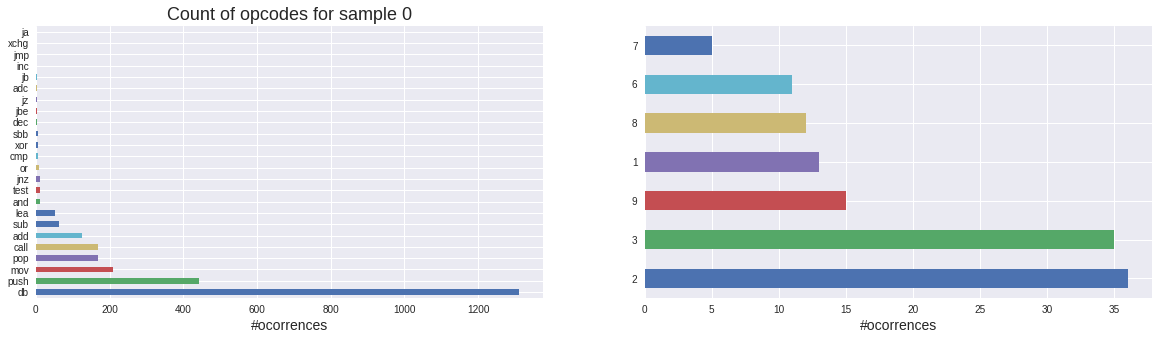

In [64]:
idx = 0

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
df_X.iloc[idx].value_counts().plot(kind = 'barh')
plt.title('Count of opcodes for sample {}'.format(idx), fontsize=18)
plt.xlabel('#ocorrences', fontsize=14)

plt.subplot(1,2,2)
df_y['targets'].value_counts().plot(kind = 'barh')
plt.xlabel('#ocorrences', fontsize=14)

## Split train and valid set

In [65]:
from sklearn.model_selection import train_test_split

In [66]:
test_size = 0.2
print('Test size: {}'.format(test_size))
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=42)

Test size: 0.2


In [67]:
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))

print('X_valid shape: {}'.format(X_valid.shape))
print('y_valid shape: {}'.format(y_valid.shape))

X_train shape: (101,)
y_train shape: (101,)
X_valid shape: (26,)
y_valid shape: (26,)


## Saving processed data

In [68]:
def save_data(X, y, file, path2save):

    os.makedirs(path2save)
    
    data ={'X':X, 'y':y}
    np.savez(path2save + file + ".npz",**data)

    print('Saved in: {}'.format(path2save))  

In [69]:
path2saveTrain = 'proc_data/train/'
path2saveValid = 'proc_data/valid/'


if not os.path.exists(path2saveTrain):
    save_data(X_train, y_train,'opcodes', path2saveTrain)
    save_data(X_valid, y_valid,'opcodes', path2saveValid)

else:
    print('Data already processed!')

Saved in: proc_data/train/
Saved in: proc_data/valid/


## N-grams

In [70]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [71]:
max_gram = 4
print('Max_grams: {}'.format(max_gram))

Max_grams: 4


In [81]:
def get_n_grams(X, max_gram = 4):
  

    print('Counting ocorrences of words. Ngram-range: {}...'.format(str((1,max_gram))))
    
    vectorizer = CountVectorizer(analyzer = "word",
                                 max_features = 300,
                                 ngram_range=(1,max_gram)) 
    
    features = vectorizer.fit_transform([" ".join(x) for x in X])

    #downscale weights for words using tf–idf: “Term Frequency times Inverse Document Frequency”.
    print('Words downscaling using TF-IDF...')

    tfidf_transformer = TfidfTransformer()
    features = tfidf_transformer.fit_transform(features)
    
    features = features.toarray()
    model_vectorized = vectorizer
    model_tfidf = tfidf_transformer

    return model_vectorized, model_tfidf, features

In [82]:
model_vectorized, model_tfidf, f_train = get_n_grams(X_train)

Counting ocorrences of words. Ngram-range: (1, 4)...
Words downscaling using TF-IDF...


In [88]:
f_valid = model_vectorized.transform([" ".join(x) for x in X_valid])
f_valid = model_tfidf.transform(f_valid)
f_valid = f_valid.toarray()

In [97]:
print('Train features shape: {}'.format(f_train.shape))
print('Valid features shape: {}'.format(f_valid.shape))

Train features shape: (101, 300)
Valid features shape: (26, 300)


# Train classification model

## Tree Ensemble

In [84]:
from sklearn.ensemble import RandomForestClassifier

In [85]:
forest = RandomForestClassifier(n_estimators = 100) 
forest = forest.fit( f_train, y_train )

In [94]:
predictions_forest = forest.predict(f_valid)

## Boosting trees

In [0]:
import xgboost as xgb

In [0]:
clf = xgb.XGBClassifier(max_depth=7,
                        n_estimators=200,
                        colsample_bytree=0.8, 
                        subsample=0.8,
                        nthread=10,
                        learning_rate=0.1)

clf.fit(f_train, y_train)

In [0]:
predictions_xgboost = clf.predict_proba(f_valid)

# Performance evaluation


In [119]:
def confusion_matrix(result, y):

    tagset = list(set(y))
    output = np.zeros((len(tagset), len(tagset)), dtype=float)
    
    for predicted, real in zip(result, y):
        output[tagset.index(predicted), tagset.index(real)] += 1

    return output / output.sum(axis=1)[:, None]
     

In [120]:
cm_forest = confusion_matrix(predictions_forest, y_train)
cm_xboost = confusion_matrix(predictions_xgboost, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [0]:
def evaluate_model(cm):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    print('Accuracy: {}'.format(accuracy))
    print('Misclass: {}\n'.format(misclass))

In [0]:
evaluate_model(cm_forest)
evaluate_model(cm_xboost)


In [131]:
def plot_confusion_matrix(cm, title):

    plt.imshow(cm, interpolation='nearest', cmap=None)
    plt.title(title, fontsize=20)
    plt.colorbar()

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plot_confusion_matrix(cm, 'Confusion matrix trainig set (RF)')

plt.subplot(1,2,1)
plot_confusion_matrix(cm, 'Confusion matrix trainig set (XgBoost)')